Projet OC n°5 : Segmenter des clients d'un site e-commerce
==========================================================

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

import sqlite3
import time

from scipy import stats
from tqdm import tqdm
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error, adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import KernelPCA
from sklearn.impute import KNNImputer

I. Préprocessing
****************

In [2]:
# Chemin vers le fichier de base de données SQLite

db_path = '../Data/olist.db'

# Connexion à la base de données
conn = sqlite3.connect(db_path)

Pour optimiser la fréquence de mise à jour de notre modèle de segmentation client sur le site de e-commerce, nous adoptons une stratégie d'analyse sur des périodes de trois mois, six mois et un an.

Cette approche nous permet d'identifier les tendances d'achat à court et long terme et d'ajuster nos stratégies marketing en conséquence.

En parallèle, nous accordons une attention particulière aux 3% de clients les plus actifs pour cerner les opportunités de fidélisation et peaufiner nos actions de marketing ciblé.

Cette méthode assure une segmentation client à jour, précise et stratégiquement alignée sur les besoins changeants du marché.

**3 Mois :**

- Cela peut capturer les tendances saisonnières ou à court terme.

- Utile pour réagir rapidement aux changements récents dans les comportements ou performances.


**6 Mois :**

- Fournit une vue plus équilibrée qui peut lisser les fluctuations à très court terme tout en capturant les tendances significatives.

- Peut aider à planifier des ajustements stratégiques ou des campagnes marketing.


**Un An :**

- Offre une perspective complète sur les tendances annuelles, y compris toutes les saisons.

- Idéal pour l'analyse de la performance annuelle, la planification stratégique à long terme, et pour comprendre l'impact des initiatives annuelles.

    A. Recuperation des clients

Recuperation des clients ayant passe plus d'une commande soit 3.014% de clients

In [3]:
# Création d'un objet Cursor pour interagir avec la base de données
cur = conn.cursor()

# Exécution d'une requête SQL pour extraire des informations sur les clients
"""
Cette requête sélectionne le nombre de commandes par client (Orders_number),

ainsi que les identifiants de commande (order_id), l'identifiant client dans la table des commandes (customer_id)
et l'identifiant unique du client (customer_unique_id).

La jointure est faite entre les tables 'orders' et 'customers' sur la base de l'identifiant client.

Les données sont regroupées par l'identifiant unique du client.

La clause 'HAVING' est utilisée pour ne considérer que les clients ayant réalisé plus d'une commande.

"""

cur.execute("""
select count(o.order_id) as 'Orders_number', o.order_id, c.customer_id, c.customer_unique_id
from orders o, customers c
where o.customer_id = c.customer_id
group by c.customer_unique_id
having count(o.order_id) > 1
"""
           )

# Récupération des résultats de la requête
# Les résultats sont stockés dans la variable 'resultats'.
resultats = cur.fetchall()

        1. Clients les plus récents (3 mois)

**Recency**

In [4]:
# Création d'un objet Cursor pour interagir avec la base de données
cur = conn.cursor()

# Exécution d'une requête SQL pour déterminer la date de la dernière commande de chaque client

"""
Cette requête sélectionne deux champs : l'identifiant unique de chaque client (customer_unique_id)
et la date de sa dernière commande (last_purchase_date) pour les 3 derniers mois disponible dans la base de données.
Une jointure est effectuée entre les tables 'customers' et 'orders' en utilisant l'identifiant client.
La fonction MAX() est utilisée pour trouver la commande la plus récente pour chaque client,
en filtrant les commandes basées sur la date du dernier mois par rapport à la date la plus récente trouvée dans les commandes.
Les résultats sont regroupés par l'identifiant unique du client pour s'assurer que chaque client est représenté une seule fois.

"""

cur.execute("""
SELECT customer_unique_id, MAX(order_purchase_timestamp) AS last_purchase_date
    FROM customers
    JOIN orders ON customers.customer_id = orders.customer_id
    WHERE order_purchase_timestamp >= (
        SELECT date(MAX(order_purchase_timestamp), '-3 month') FROM orders
    ) AND order_status != 'canceled'
    GROUP BY customer_unique_id;
"""
)

Recency_last_three_month = cur.fetchall()

**Frequency**

In [5]:
# Création d'un objet Cursor pour interagir avec la base de données
cur = conn.cursor()


# Requête pour calculer la Frequency pour les 3 derniers mois
"""
 Requête SQL pour calculer la fréquence des commandes par client pour les 3 derniers mois.
Cette requête compte le nombre total de commandes passées par chaque client dans les 3 derniers mois.
Les commandes sont filtrées pour ne prendre en compte que celles réalisées durant les 3 derniers mois par rapport à la date la plus récente trouvée dans la base de données.
Les résultats sont ensuite regroupés par l'identifiant unique du client.

"""

cur.execute("""
    SELECT customer_unique_id, COUNT(order_id) AS total_orders
    FROM customers 
    JOIN orders ON customers.customer_id = orders.customer_id
    WHERE order_purchase_timestamp >= (
        SELECT date(MAX(order_purchase_timestamp), '-3 month') FROM orders
    ) AND order_status != 'canceled'
    GROUP BY customer_unique_id;
""")

# Récupération des résultats de la requête
# Les résultats sont stockés dans la variable 'Recency'.
Frequency_last_three_month = cur.fetchall()

**Monetary**

In [6]:
# Création d'un objet Cursor pour interagir avec la base de données
cur = conn.cursor()


# Requête pour calculer le Monetary pour les 3 derniers mois
"""
Requête SQL pour calculer le montant total dépensé par chaque client pour les 3 derniers mois.
Cette requête calcule la somme totale des valeurs de paiement pour toutes les commandes passées par chaque client dans les 3 derniers mois.
Les paiements sont filtrés pour ne prendre en compte que ceux réalisés durant les 3 derniers mois par rapport à la date la plus récente trouvée dans la base de données.
Les résultats sont ensuite regroupés par l'identifiant unique du client.

"""

cur.execute("""
    SELECT customer_unique_id, SUM(payment_value) AS total_spent
    FROM customers 
    JOIN orders ON customers.customer_id = orders.customer_id
    JOIN order_pymts ON orders.order_id = order_pymts.order_id
    WHERE order_purchase_timestamp >= (
        SELECT date(MAX(order_purchase_timestamp), '-3 month') FROM orders
    ) AND order_status != 'canceled'
    GROUP BY customer_unique_id;
""")

# Récupération des résultats de la requête
# Les résultats sont stockés dans la variable 'Recency'.
Monetary_last_three_month = cur.fetchall()

***Création des Jeux de Données et feature Engineering pour les 3 derniers mois***

In [7]:
# Convertir les résultats SQL en DataFrames Pandas
data_importance_last_three_month = pd.DataFrame(resultats, columns=['Orders_number', 'order_id', 'customer_id', 'customer_unique_id'])
data_recency_last_three_month = pd.DataFrame(Recency_last_three_month, columns=['customer_unique_id', 'last_purchase_date'])
data_frequency_last_three_month = pd.DataFrame(Frequency_last_three_month, columns=['customer_unique_id', 'total_orders'])
data_monetary_last_three_month = pd.DataFrame(Monetary_last_three_month, columns=['customer_unique_id', 'total_spent'])

# Fusionner les DataFrames pour créer un seul DataFrame avec toutes les informations
data_merged_last_three_month = data_recency_last_three_month.merge(data_frequency_last_three_month, on='customer_unique_id', how='outer')
data_merged_last_three_month = data_merged_last_three_month.merge(data_monetary_last_three_month, on='customer_unique_id', how='outer')
data_merged_last_three_month = data_merged_last_three_month.merge(data_importance_last_three_month[['customer_unique_id', 'Orders_number']], on='customer_unique_id', how='outer')

# Avant de supprimer 'Orders_number', vous on créer d'abord  la colonne 'Importance'
data_merged_last_three_month['Importance'] = data_merged_last_three_month['Orders_number'] > 1

# Ensuite, on supprimer la colonne 'Orders_number'
data_merged_last_three_month.drop('Orders_number', axis=1, inplace=True)

# Renommer le DataFrame final en data_last_three_month
data_last_three_month = data_merged_last_three_month.copy()
data_last_three_month.columns = ['customer_unique_id', 'Recency', 'Frequency', 'Monetary', 'Importance']

# Afficher le DataFrame final
data_last_three_month.head()


,customer_unique_id,Recency,Frequency,Monetary,Importance
0,000ec5bff359e1c0ad76a81a45cb598f,2018-08-21 11:34:26,1.0,27.75,False
1,000fbf0473c10fc1ab6f8d2d286ce20c,2018-07-26 09:43:52,1.0,362.38,False
2,0015752e079902b12cd00b9b7596276b,2018-08-02 18:23:51,1.0,74.82,False
3,00172711b30d52eea8b313a7f2cced02,2018-07-28 00:23:49,1.0,122.07,True
4,001928b561575b2821c92254a2327d06,2018-08-24 21:17:00,1.0,164.81,False


        2. Clients moins récents (6 mois)

**Recency**

In [8]:
# Création d'un objet Cursor pour interagir avec la base de données
cur = conn.cursor()

# Exécution d'une requête SQL pour déterminer la date de la dernière commande de chaque client

"""
Cette requête sélectionne deux champs : l'identifiant unique de chaque client (customer_unique_id)
et la date de sa dernière commande (last_purchase_date) pour les 6 derniers mois disponible dans la base de données.
Une jointure est effectuée entre les tables 'customers' et 'orders' en utilisant l'identifiant client.
La fonction MAX() est utilisée pour trouver la commande la plus récente pour chaque client,
en filtrant les commandes basées sur la date des derniers six mois par rapport à la date la plus récente trouvée dans les commandes.
Les résultats sont regroupés par l'identifiant unique du client pour s'assurer que chaque client est représenté une seule fois.

"""

cur.execute("""
SELECT customer_unique_id, MAX(order_purchase_timestamp) AS last_purchase_date
    FROM customers
    JOIN orders ON customers.customer_id = orders.customer_id
    WHERE order_purchase_timestamp >= (
        SELECT date(MAX(order_purchase_timestamp), '-6 month') FROM orders
    )
    GROUP BY customer_unique_id;
"""
)

Recency_last_six_month = cur.fetchall()

**Frequency**

In [9]:
# Création d'un objet Cursor pour interagir avec la base de données
cur = conn.cursor()


# Requête pour calculer la Frequency pour les 6 derniers mois
"""
 Requête SQL pour calculer la fréquence des commandes par client pour les 6 derniers mois.
Cette requête compte le nombre total de commandes passées par chaque client dans les 6 derniers mois.
Les commandes sont filtrées pour ne prendre en compte que celles réalisées durant les derniers six mois par rapport à la date la plus récente trouvée dans la base de données.
Les résultats sont ensuite regroupés par l'identifiant unique du client.

"""

cur.execute("""
    SELECT customer_unique_id, COUNT(order_id) AS total_orders
    FROM customers 
    JOIN orders ON customers.customer_id = orders.customer_id
    WHERE order_purchase_timestamp >= (
        SELECT date(MAX(order_purchase_timestamp), '-6 month') FROM orders
    )
    GROUP BY customer_unique_id;
""")

# Récupération des résultats de la requête
# Les résultats sont stockés dans la variable 'Recency'.
Frequency_last_six_month = cur.fetchall()

**Monetary**

In [10]:
# Création d'un objet Cursor pour interagir avec la base de données
cur = conn.cursor()


# Requête pour calculer le Monetary pour les 6 derniers mois
"""
Requête SQL pour calculer le montant total dépensé par chaque client pour les 6 derniers mois.
Cette requête calcule la somme totale des valeurs de paiement pour toutes les commandes passées par chaque client dans les 6 derniers mois.
Les paiements sont filtrés pour ne prendre en compte que ceux réalisés durant les derniers six mois par rapport à la date la plus récente trouvée dans la base de données.
Les résultats sont ensuite regroupés par l'identifiant unique du client.

"""

cur.execute("""
    SELECT customer_unique_id, SUM(payment_value) AS total_spent
    FROM customers 
    JOIN orders ON customers.customer_id = orders.customer_id
    JOIN order_pymts ON orders.order_id = order_pymts.order_id
    WHERE order_purchase_timestamp >= (
        SELECT date(MAX(order_purchase_timestamp), '-6 month') FROM orders
    )
    GROUP BY customer_unique_id;
""")

# Récupération des résultats de la requête
# Les résultats sont stockés dans la variable 'Recency'.
Monetary_last_six_month  = cur.fetchall()

**Création des Jeux de Données et feature Engineering pour les 6 derniers mois**

In [11]:
# Conversion des résultats SQL en DataFrames Pandas
data_importance_last_six_month = pd.DataFrame(resultats, columns=['Orders_number', 'order_id', 'customer_id', 'customer_unique_id'])
data_recency_last_six_month = pd.DataFrame(Recency_last_six_month, columns=['customer_unique_id', 'last_purchase_date'])
data_frequency_last_six_month = pd.DataFrame(Frequency_last_six_month, columns=['customer_unique_id', 'total_orders'])
data_monetary_last_six_month = pd.DataFrame(Monetary_last_six_month, columns=['customer_unique_id', 'total_spent'])

# Fusionner les DataFrames pour créer un seul DataFrame avec toutes les informations
data_last_six_month = data_recency_last_six_month.merge(data_frequency_last_six_month, on='customer_unique_id', how='outer')
data_last_six_month = data_last_six_month.merge(data_monetary_last_six_month, on='customer_unique_id', how='outer')
data_last_six_month = data_last_six_month.merge(data_importance_last_six_month[['customer_unique_id', 'Orders_number']], on='customer_unique_id', how='outer')

# Remplir les valeurs manquantes pour 'Importance' et renommer les colonnes pour clarifier
data_last_six_month['Importance'] = data_last_six_month['Orders_number'] > 1
data_last_six_month.drop('Orders_number', axis=1, inplace=True)
data_last_six_month.columns = ['customer_unique_id', 'Recency', 'Frequency', 'Monetary', 'Importance']

# Afficher le DataFrame final
data_last_six_month.head()

,customer_unique_id,Recency,Frequency,Monetary,Importance
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1.0,141.90,False
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1.0,27.19,False
2,00050ab1314c0e55a6ca13cf7181fecf,2018-04-20 12:57:23,1.0,35.38,False
3,000949456b182f53c18b68d6babc79c1,2018-04-23 09:55:46,1.0,82.05,False
4,000e309254ab1fc5ba99dd469d36bdb4,2018-06-25 09:53:57,1.0,78.42,False


        3. Clients sur la dernière année

**Recency**

In [12]:
# Création d'un objet Cursor pour interagir avec la base de données
cur = conn.cursor()

# Exécution d'une requête SQL pour déterminer la date de la dernière commande de chaque client

"""
Cette requête sélectionne deux champs : l'identifiant unique de chaque client (customer_unique_id)
et la date de sa dernière commande (last_purchase_date) pour la dernière année disponible dans la base de données.
Une jointure est effectuée entre les tables 'customers' et 'orders' en utilisant l'identifiant client.
La fonction MAX() est utilisée pour trouver la commande la plus récente pour chaque client,
en filtrant les commandes basées sur la dernière année par rapport à la date la plus récente trouvée dans les commandes.
Les résultats sont regroupés par l'identifiant unique du client pour s'assurer que chaque client est représenté une seule fois.

"""

cur.execute("""
SELECT customer_unique_id, MAX(order_purchase_timestamp) AS last_purchase_date
    FROM customers
    JOIN orders ON customers.customer_id = orders.customer_id
    WHERE order_purchase_timestamp >= (
        SELECT date(MAX(order_purchase_timestamp), '-12 month') FROM orders
    )
    GROUP BY customer_unique_id;
"""
)

Recency_last_year = cur.fetchall()

**Frequency**

In [13]:
# Création d'un objet Cursor pour interagir avec la base de données
cur = conn.cursor()


# Requête pour calculer la Frequency pour la dernière année
"""
 Requête SQL pour calculer la fréquence des commandes par client pour la dernière année.
Cette requête compte le nombre total de commandes passées par chaque client dans la dernière année.
Les commandes sont filtrées pour ne prendre en compte que celles réalisées durant la dernière année par rapport à la date la plus récente trouvée dans la base de données.
Les résultats sont ensuite regroupés par l'identifiant unique du client.

"""

cur.execute("""
    SELECT customer_unique_id, COUNT(order_id) AS total_orders
    FROM customers 
    JOIN orders ON customers.customer_id = orders.customer_id
    WHERE order_purchase_timestamp >= (
        SELECT date(MAX(order_purchase_timestamp), '-12 month') FROM orders
    )
    GROUP BY customer_unique_id;
""")

# Récupération des résultats de la requête
# Les résultats sont stockés dans la variable 'Recency'.
Frequency_last_year = cur.fetchall()

**Monetary**

In [14]:
# Création d'un objet Cursor pour interagir avec la base de données
cur = conn.cursor()


# Requête pour calculer le Monetary pour la dernière année
"""
Requête SQL pour calculer le montant total dépensé par chaque client pour la dernière année.
Cette requête calcule la somme totale des valeurs de paiement pour toutes les commandes passées par chaque client dans la dernière année.
Les paiements sont filtrés pour ne prendre en compte que ceux réalisés durant durant la dernière année par rapport à la date la plus récente trouvée dans la base de données.
Les résultats sont ensuite regroupés par l'identifiant unique du client.

"""

cur.execute("""
    SELECT customer_unique_id, SUM(payment_value) AS total_spent
    FROM customers 
    JOIN orders ON customers.customer_id = orders.customer_id
    JOIN order_pymts ON orders.order_id = order_pymts.order_id
    WHERE order_purchase_timestamp >= (
        SELECT date(MAX(order_purchase_timestamp), '-12 month') FROM orders
    )
    GROUP BY customer_unique_id;
""")

# Récupération des résultats de la requête
# Les résultats sont stockés dans la variable 'Recency'.
Monetary_last_year = cur.fetchall()

**Création des Jeux de Données et feature Engineering pour la dernière année**

In [15]:
# Conversion des résultats SQL en DataFrames Pandas pour la dernière année
data_importance_last_year = pd.DataFrame(resultats, columns=['Orders_number', 'order_id', 'customer_id', 'customer_unique_id'])
data_recency_last_year = pd.DataFrame(Recency_last_year, columns=['customer_unique_id', 'last_purchase_date'])
data_frequency_last_year = pd.DataFrame(Frequency_last_year, columns=['customer_unique_id', 'total_orders'])
data_monetary_last_year = pd.DataFrame(Monetary_last_year, columns=['customer_unique_id', 'total_spent'])

# Fusionner les DataFrames pour créer un seul DataFrame avec toutes les informations pour la dernière année
data_last_year = data_recency_last_year.merge(data_frequency_last_year, on='customer_unique_id', how='outer')
data_last_year = data_last_year.merge(data_monetary_last_year, on='customer_unique_id', how='outer')
data_last_year = data_last_year.merge(data_importance_last_year[['customer_unique_id', 'Orders_number']], on='customer_unique_id', how='outer')

# Remplir les valeurs manquantes pour 'Importance' et renommer les colonnes pour clarifier
data_last_year['Importance'] = data_last_year['Orders_number'] > 1
data_last_year.drop('Orders_number', axis=1, inplace=True)
data_last_year.columns = ['customer_unique_id', 'Recency', 'Frequency', 'Monetary', 'Importance']

# Afficher le DataFrame final pour la dernière année
data_last_year.head()

,customer_unique_id,Recency,Frequency,Monetary,Importance
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1.0,141.90,False
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1.0,27.19,False
2,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1.0,196.89,False
3,0004bd2a26a76fe21f786e4fbd80607f,2018-04-05 19:33:16,1.0,166.98,False
4,00050ab1314c0e55a6ca13cf7181fecf,2018-04-20 12:57:23,1.0,35.38,False


    B. Nettoyage du jeu de données

Valeurs manquantes dans data_last_year:


customer_unique_id    0.000000
Recency               1.105021
Frequency             1.105021
Monetary              1.105021
Importance            0.000000
dtype: float64

corrélation entre les valeurs manquantes dans data_last_year:


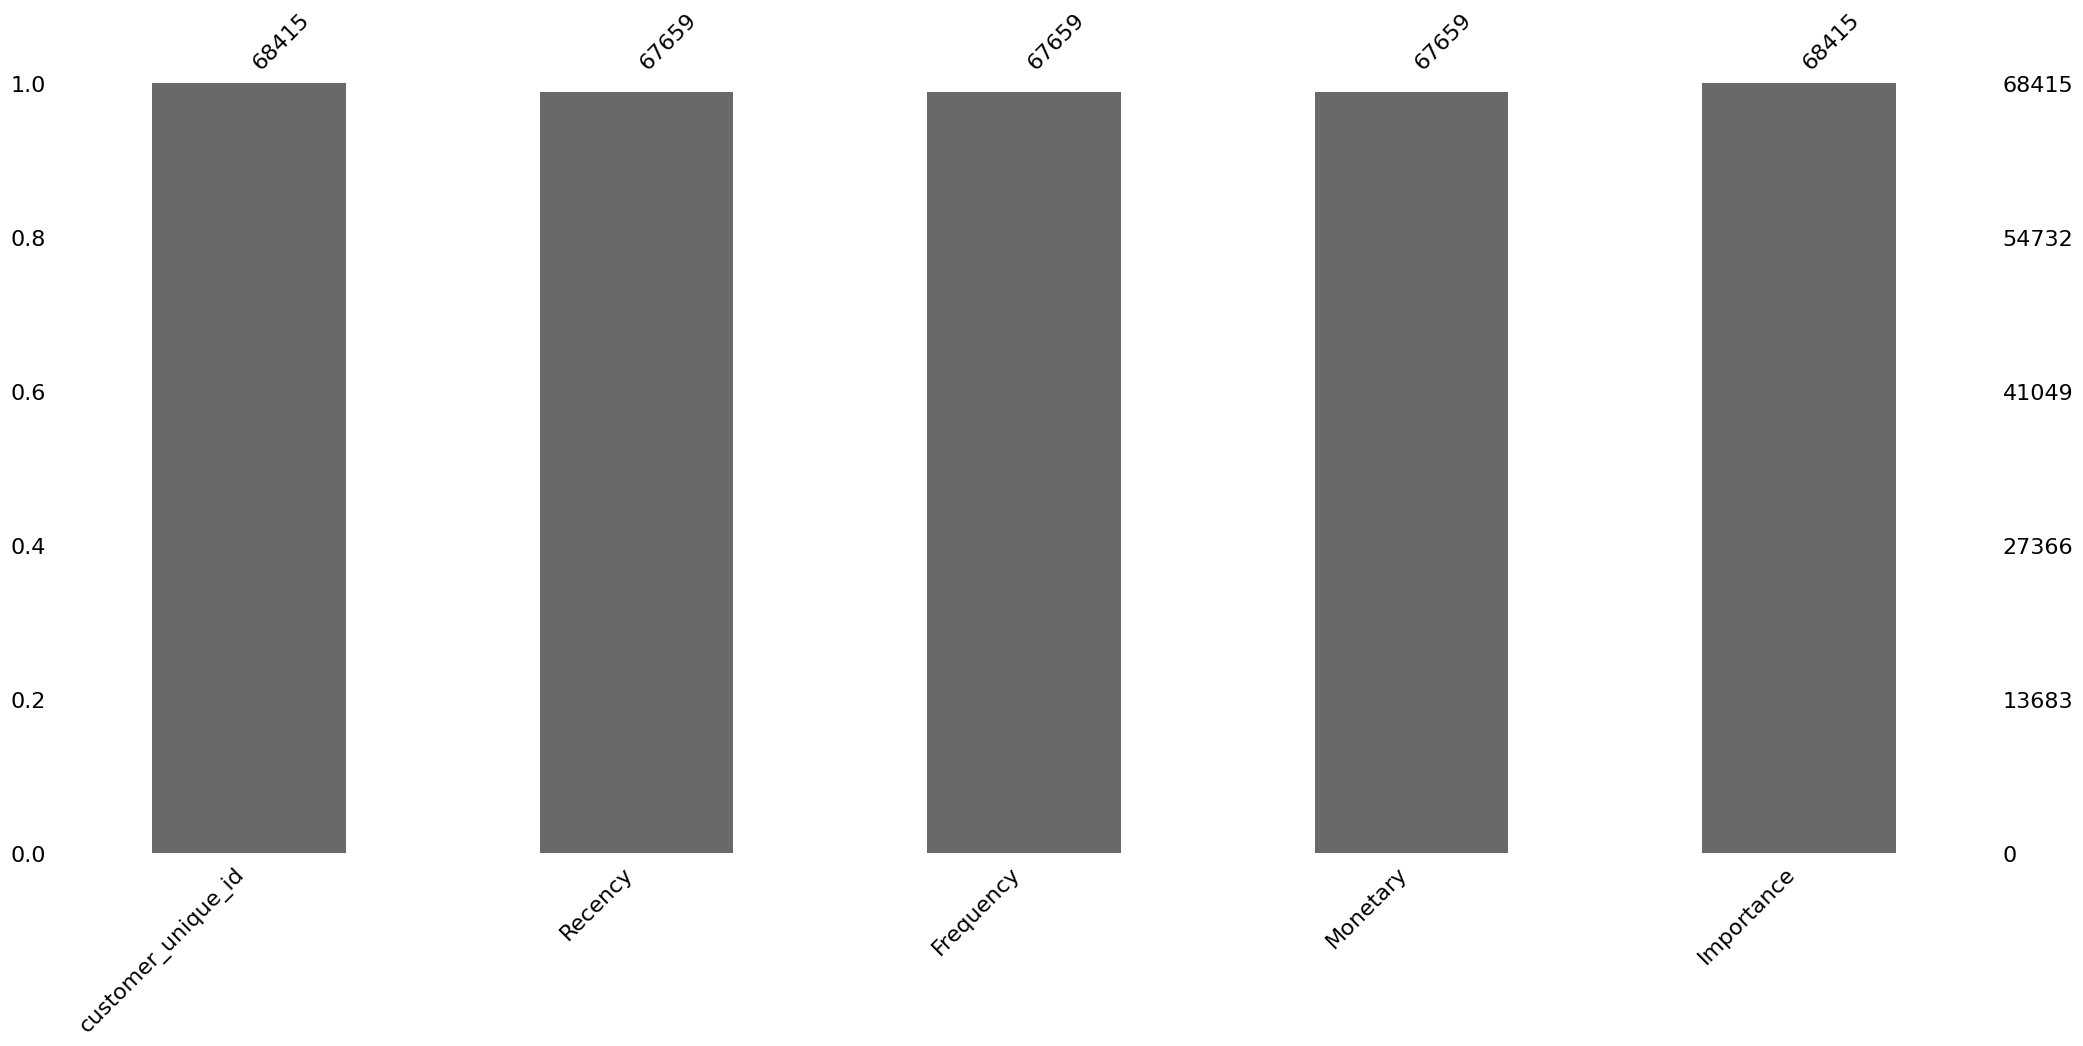

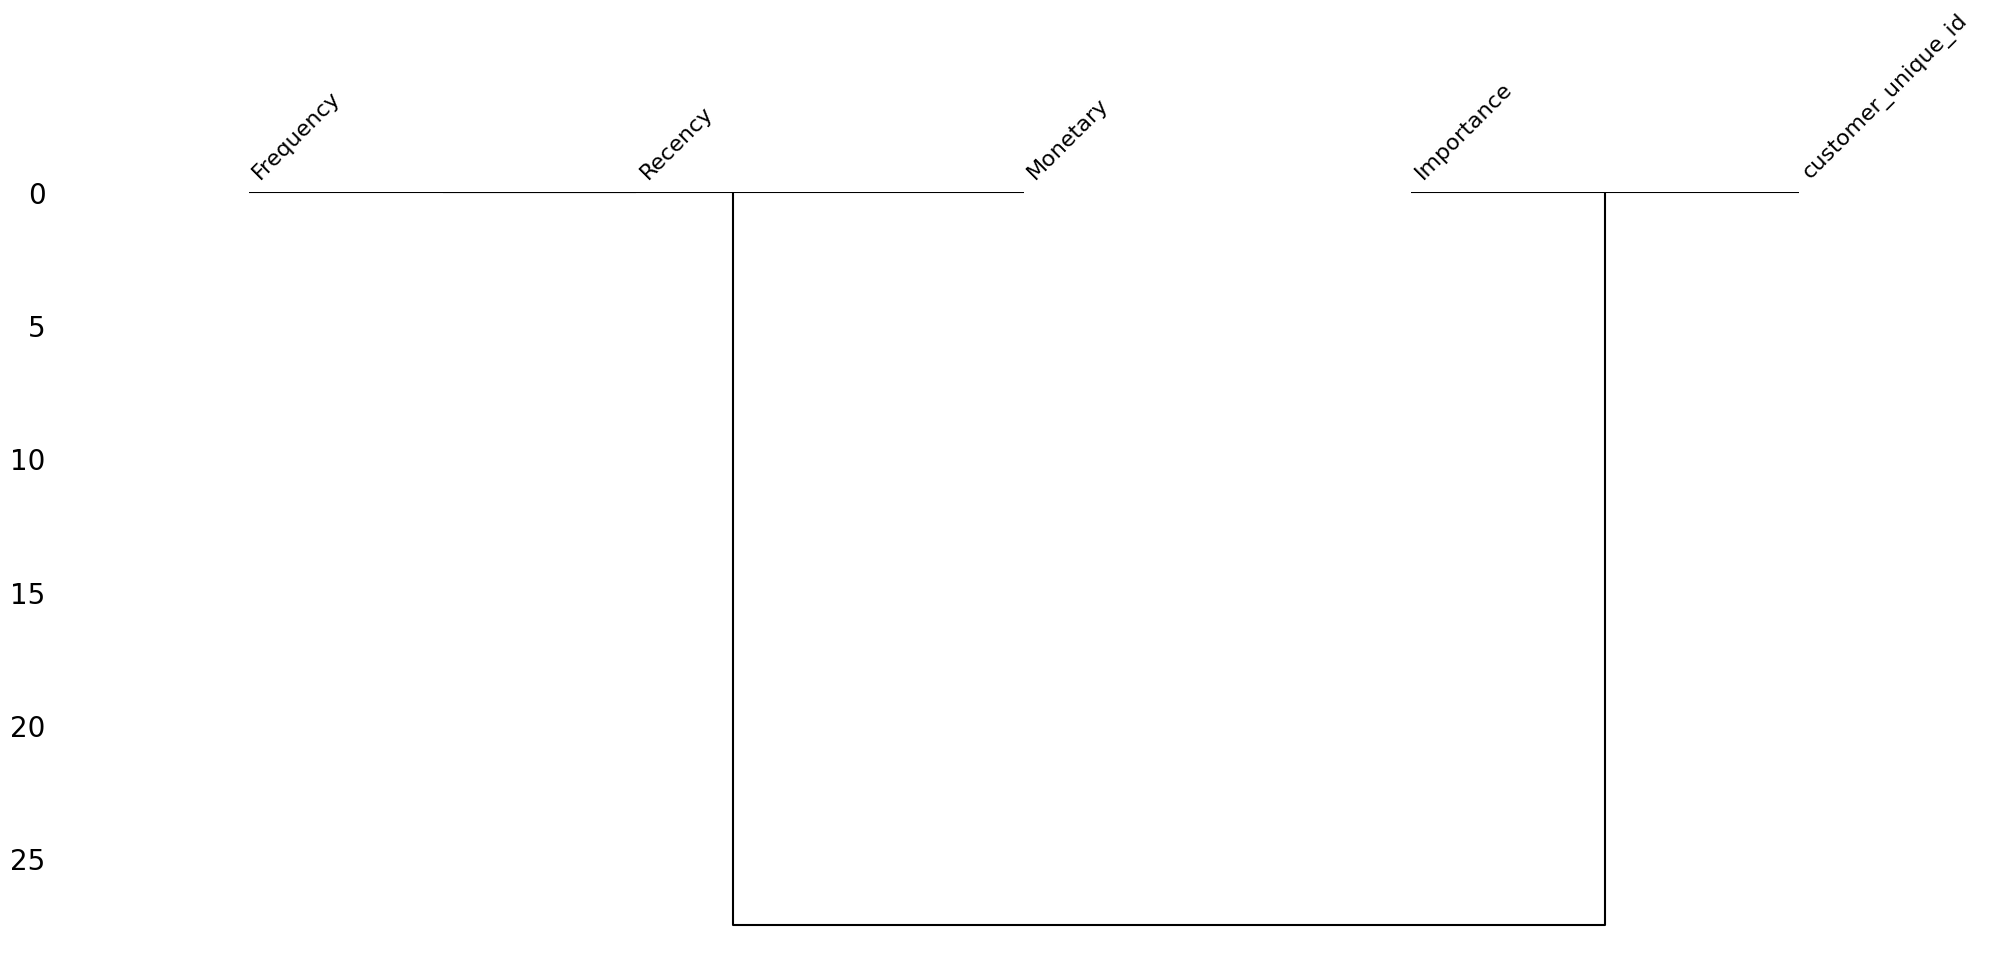

Valeurs manquantes dans data_last_six_month:


customer_unique_id    0.000000
Recency               6.510128
Frequency             6.510128
Monetary              6.510128
Importance            0.000000
dtype: float64

corrélation entre les valeurs manquantes dans data_last_six_month:


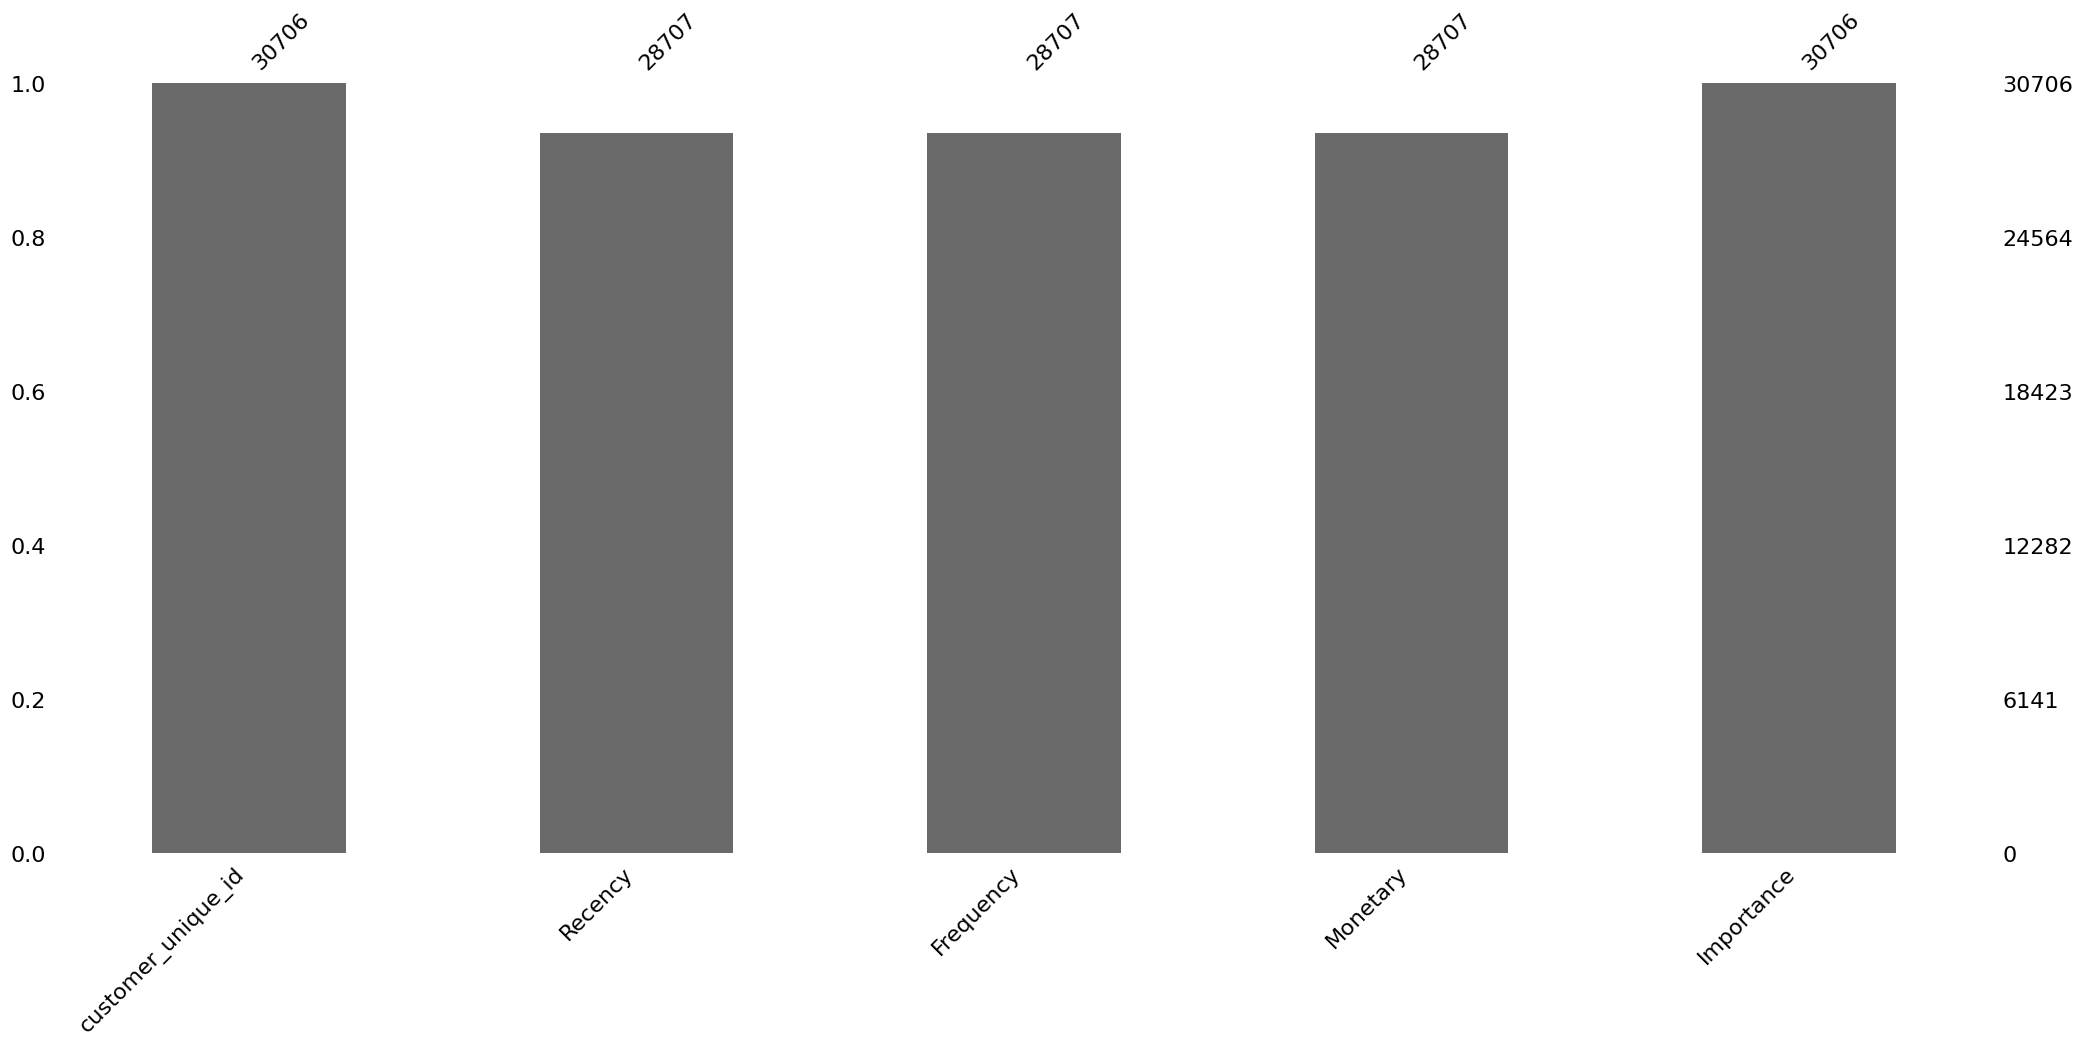

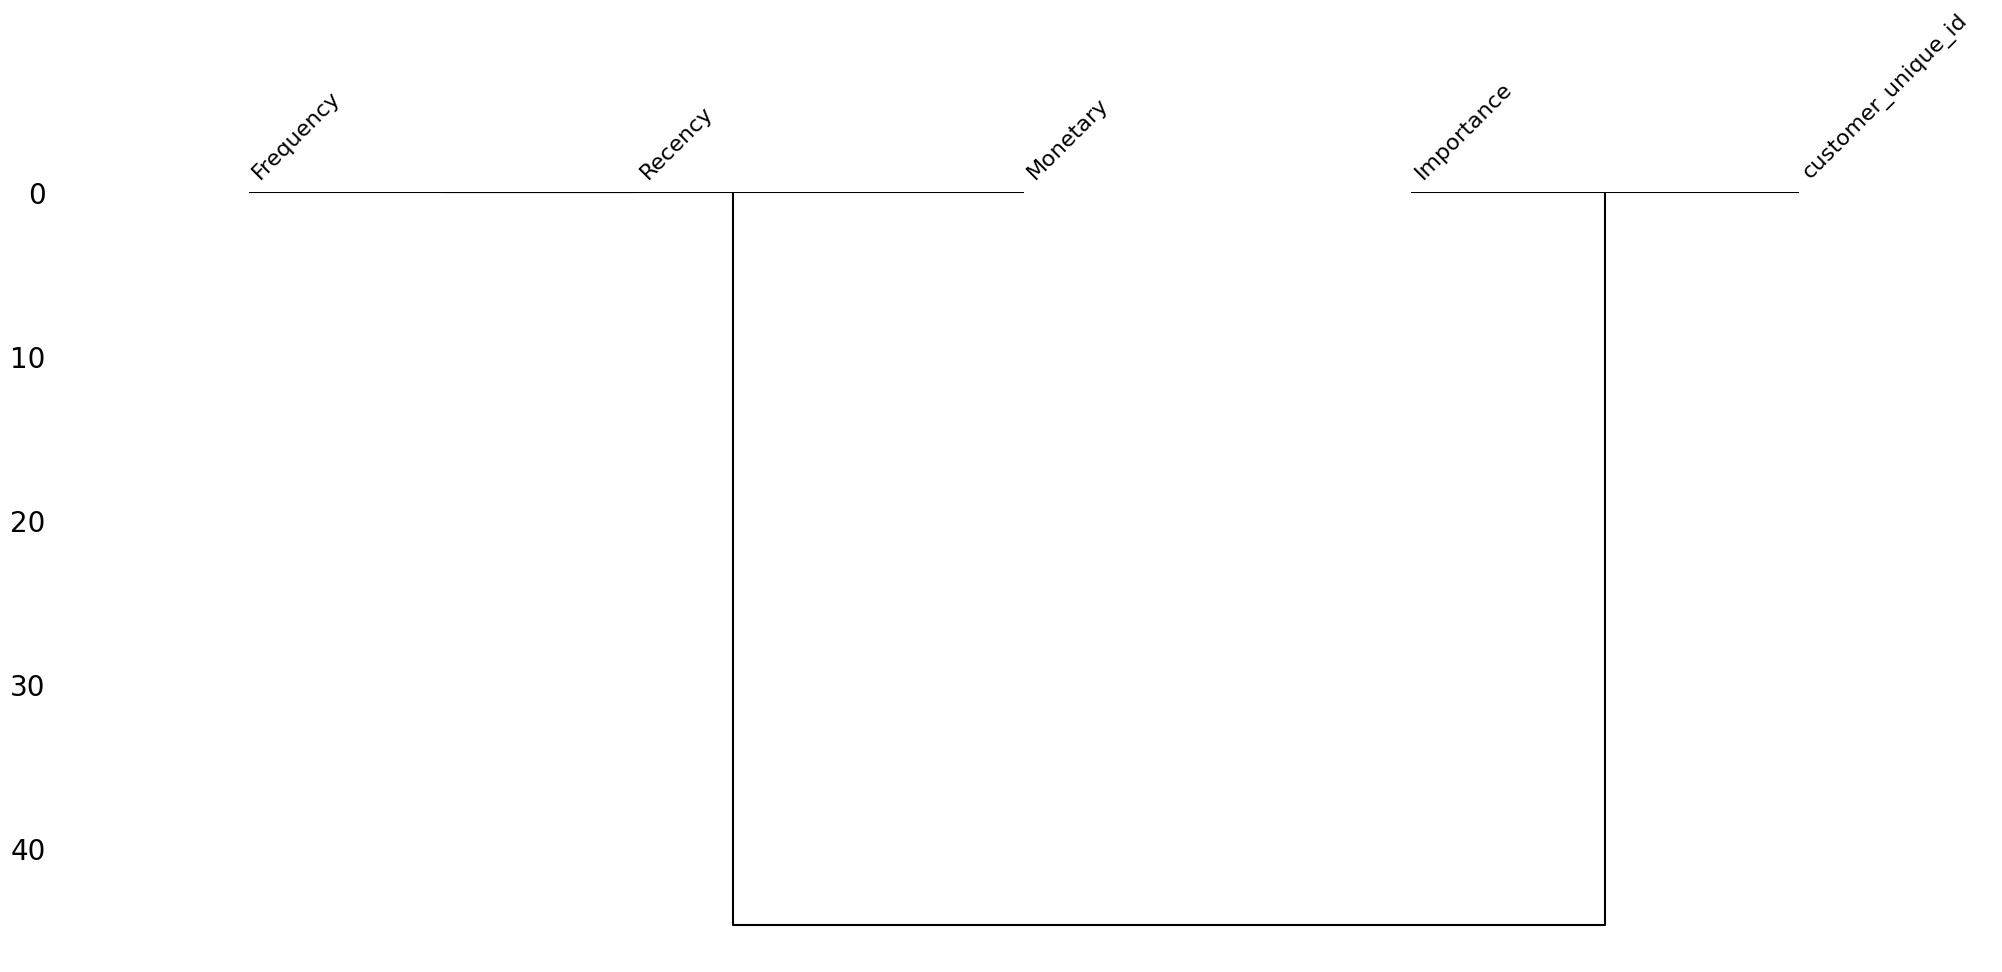

Valeurs manquantes dans data_last_three_month:


customer_unique_id     0.000000
Recency               20.846209
Frequency             20.846209
Monetary              20.846209
Importance             0.000000
dtype: float64

corrélation entre les valeurs manquantes dans data_last_three_month:


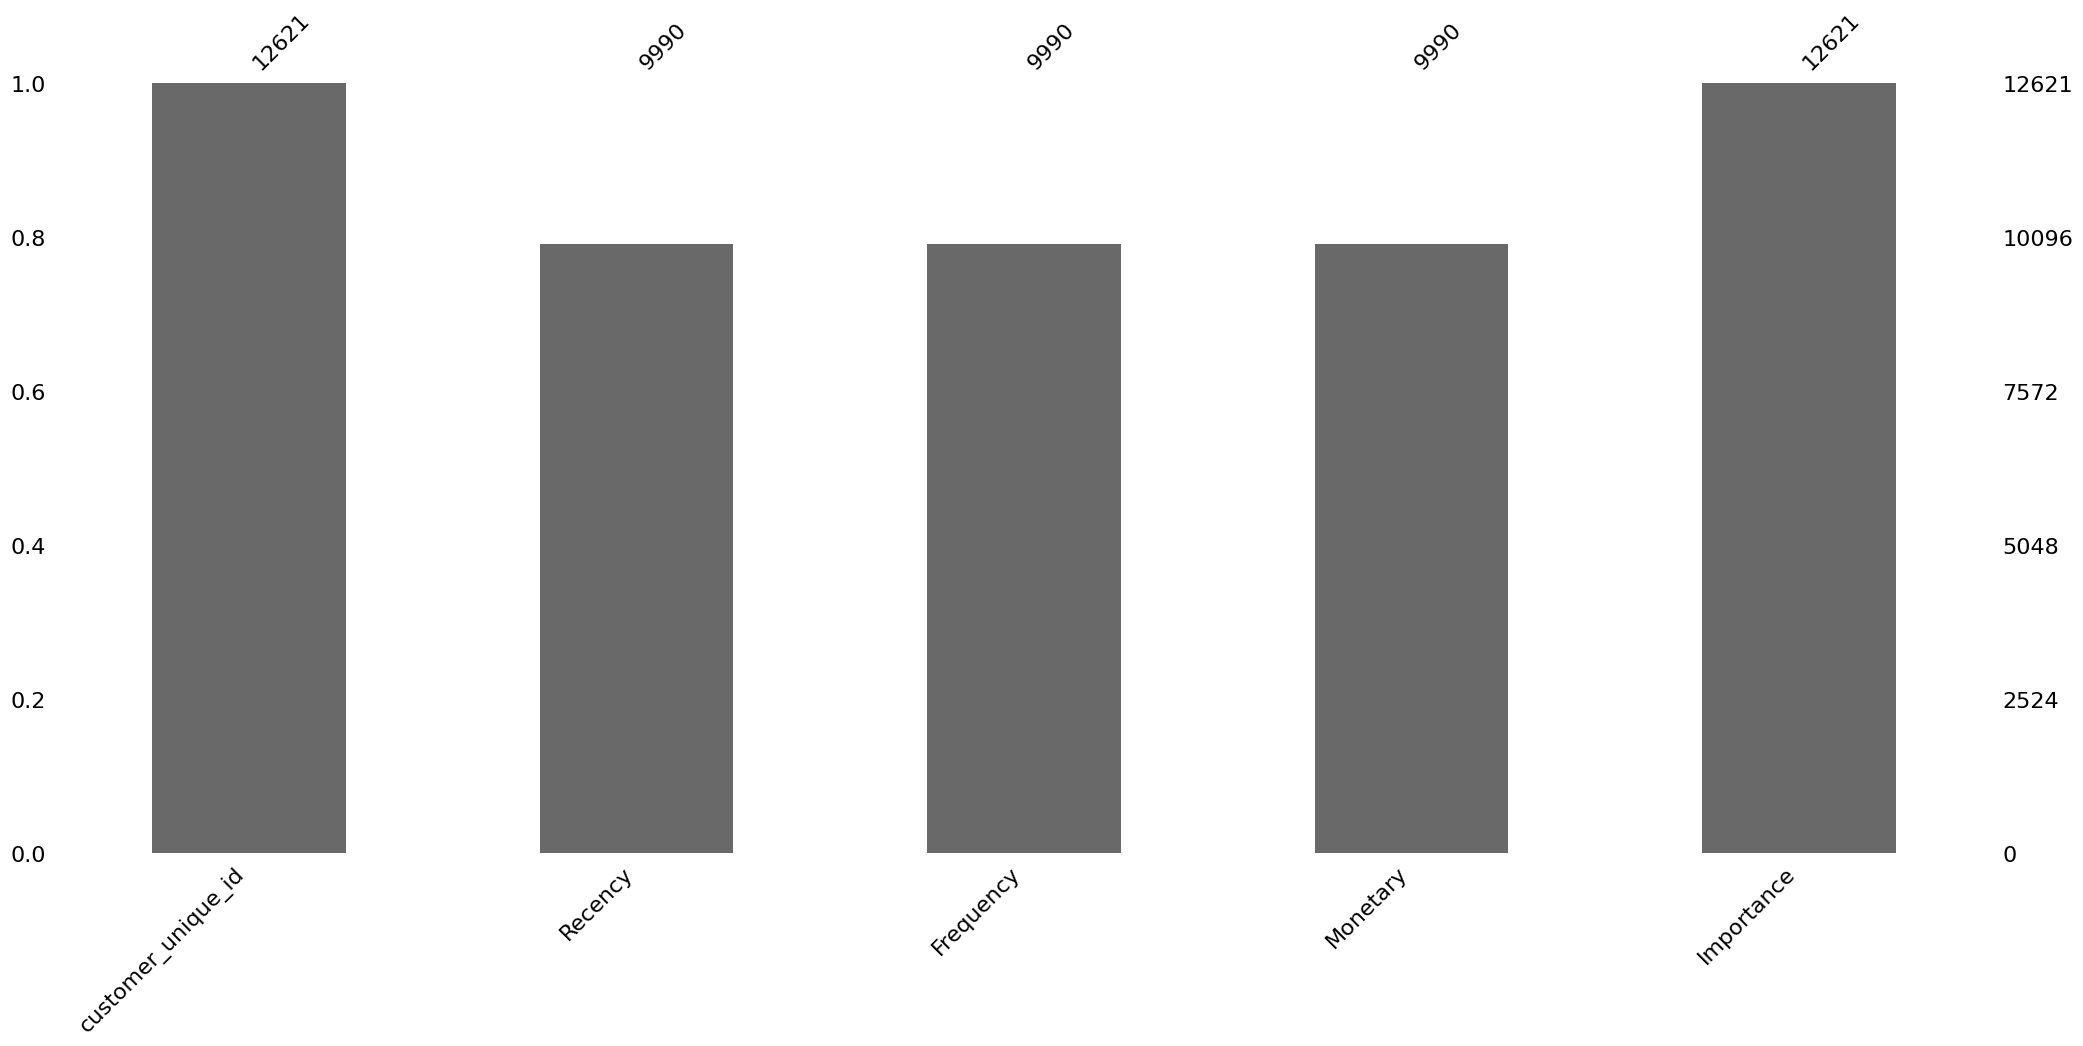

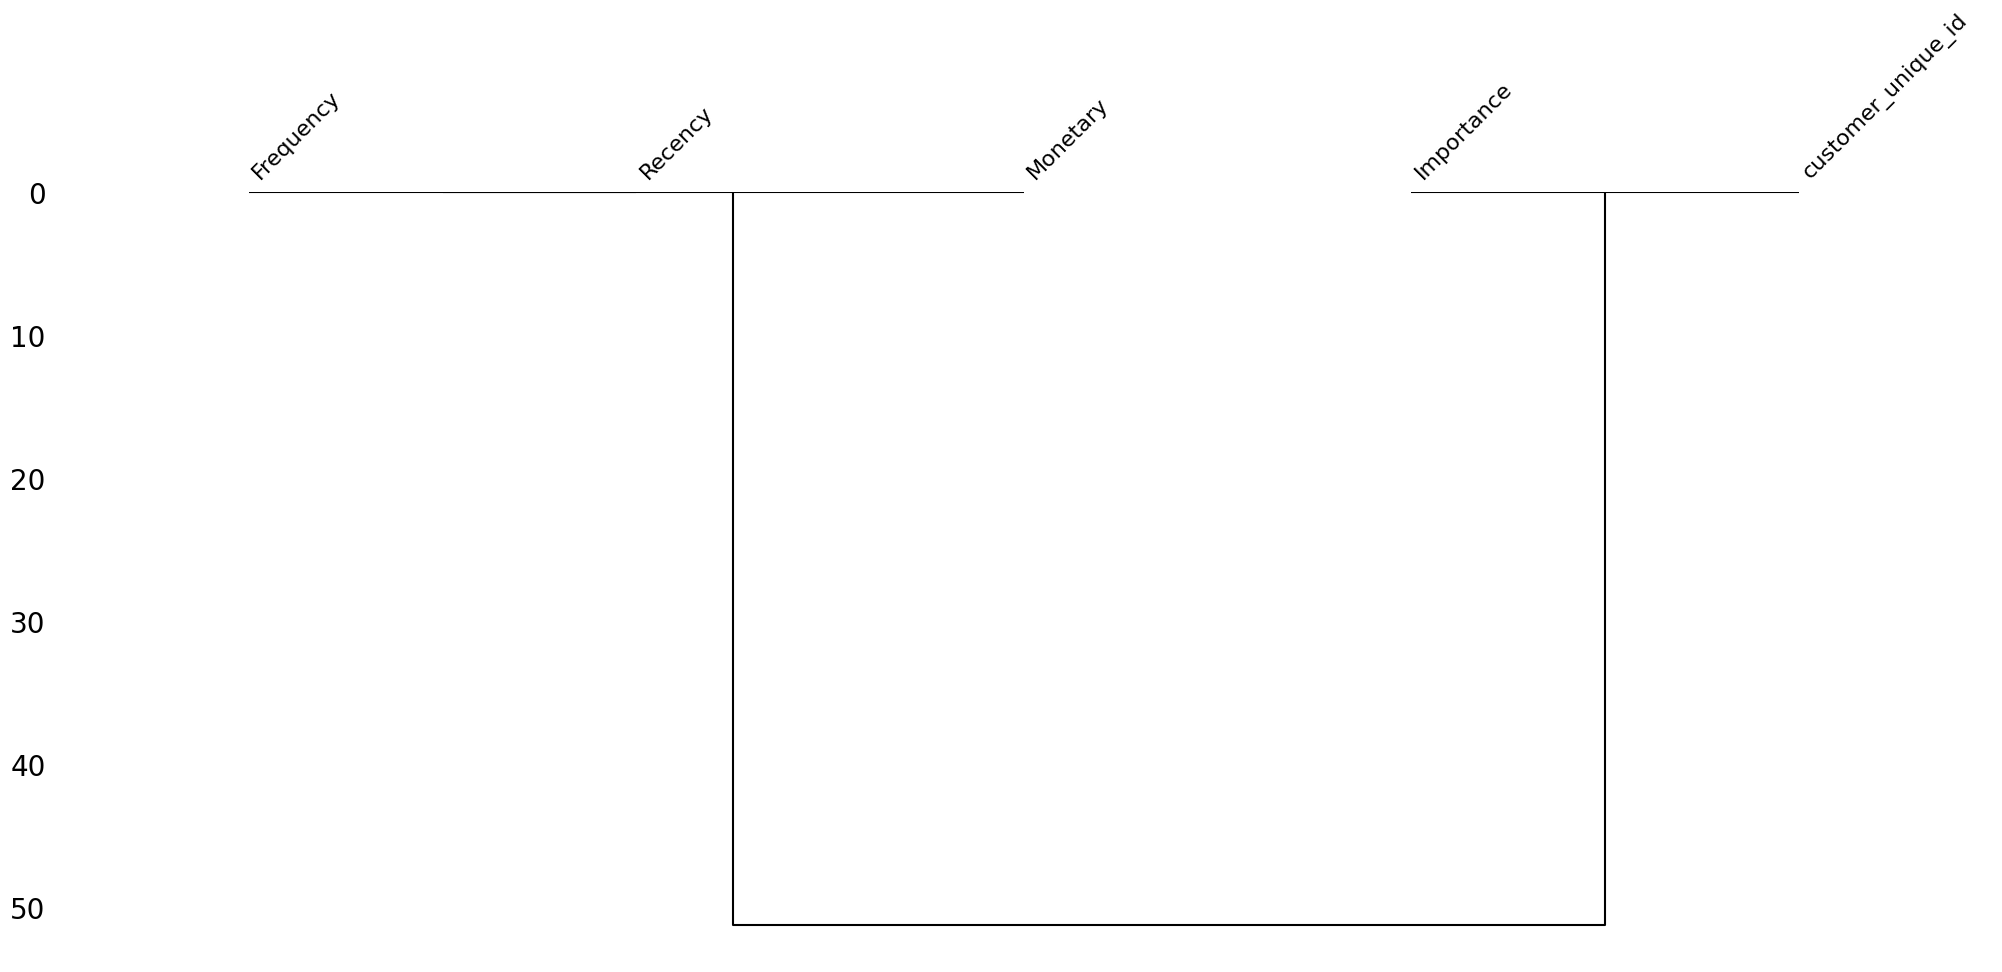

In [16]:
# Liste des noms et des DataFrames pour itération
dataframes_info = [
    ("data_last_year", data_last_year),
    ("data_last_six_month", data_last_six_month),
    ("data_last_three_month", data_last_three_month)
]

for data_name, data in dataframes_info:
    print(f"Valeurs manquantes dans {data_name}:")
    display(data.isnull().sum() / len(data) * 100)
    msno.bar(data)
    print(f"corrélation entre les valeurs manquantes dans {data_name}:")
    msno.dendrogram(data)
    plt.show()

L'analyse des dendrogrammes révèle une classification des valeurs manquantes en tant que MNAR (Missing Not At Random). 

Cela signifie que la probabilité qu'une donnée soit manquante dépend des valeurs manquantes elles-mêmes ou de d'autres variables non observées. 

Les tests de normalité peuvent fournir des indices supplémentaires sur la distribution des données et aider à choisir l'approche d'imputation la plus appropriée.

Une distribution normale peut indiquer une prédilection pour des méthodes paramétriques telles que l'imputation par régression, tandis que des distributions non normales pourraient favoriser des méthodes non paramétriques comme KNN ou MissForest.

In [17]:
def convert_recency_to_days(data, date_column):
    # Convertir les chaînes de caractères en dates
    data[date_column] = pd.to_datetime(data[date_column])
    # Trouver la date la plus récente
    most_recent_date = data[date_column].max()
    # Calculer la différence en jours par rapport à cette date la plus récente
    data['Recency'] = (most_recent_date - data[date_column]).dt.days
    return data

# Initialiser DataFrame pour les résultats des tests
results_data = pd.DataFrame(columns=['DataFrame', 'Variable', 'Test', 'Statistique', 'P-Value', 'Normalité'])

# Liste des DataFrames à traiter
dataframes = [data_last_year, data_last_six_month, data_last_three_month]
dataframe_names = ['Dernière année', 'Derniers six mois', 'Dernier tois mois']

# Colonnes à utiliser pour l'imputation KNN
columns_with_missing_values = ['Recency', 'Frequency', 'Monetary']

# Tester chaque variable quantitative dans chaque DataFrame
variables_to_test = ['Recency', 'Frequency', 'Monetary']  # Utiliser 'Recency' au lieu de 'Recency_days'
alpha = 0.05

for data_name, data in zip(dataframe_names, dataframes):
    convert_recency_to_days(data, 'Recency')
    for var in variables_to_test:
        values = data[var].dropna()

        # Shapiro-Wilk Test
        shapiro_stat, shapiro_p = stats.shapiro(values)
        results_data = pd.concat([results_data, pd.DataFrame({
            'DataFrame': [data_name],
            'Variable': [var],
            'Test': ['Shapiro-Wilk'],
            'Statistique': [shapiro_stat],
            'P-Value': [shapiro_p],
            'Normalité': ['Non' if shapiro_p < alpha else 'Oui']
        })])

        # Kolmogorov-Smirnov Test
        ks_stat, ks_p = stats.kstest(values, 'norm', args=(values.mean(), values.std()))
        results_data = pd.concat([results_data, pd.DataFrame({
            'DataFrame': [data_name],
            'Variable': [var],
            'Test': ['Kolmogorov-Smirnov'],
            'Statistique': [ks_stat],
            'P-Value': [ks_p],
            'Normalité': ['Non' if ks_p < alpha else 'Oui']
        })])

        # Anderson-Darling Test
        ad_stat, ad_crit_vals, ad_sig_level = stats.anderson(values, dist='norm')
        ad_result = 'Non' if any(ad_stat > crit_val for crit_val, sig_lvl in zip(ad_crit_vals, ad_sig_level) if sig_lvl >= (alpha*100)) else 'Oui'
        results_data = pd.concat([results_data, pd.DataFrame({
            'DataFrame': [data_name],
            'Variable': [var],
            'Test': ['Anderson-Darling'],
            'Statistique': [ad_stat],
            'P-Value': ['N/A'],
            'Normalité': [ad_result]
        })])

        # D'Agostino and Pearson's Test
        dp_stat, dp_p = stats.normaltest(values)
        results_data = pd.concat([results_data, pd.DataFrame({
            'DataFrame': [data_name],
            'Variable': [var],
            'Test': ["D'Agostino-Pearson"],
            'Statistique': [dp_stat],
            'P-Value': [dp_p],
            'Normalité': ['Non' if dp_p < alpha else 'Oui']
        })])

results_data

C:\Users\laure\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\laure\AppData\Local\Temp\ipykernel_32008\178183004.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_data = pd.concat([results_data, pd.DataFrame({
C:\Users\laure\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\laure\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be acc

,DataFrame,Variable,Test,Statistique,P-Value,Normalité
0,Dernière année,Recency,Shapiro-Wilk,9.562536e-01,0.0,Non
0,Dernière année,Recency,Kolmogorov-Smirnov,5.927176e-02,0.0,Non
0,Dernière année,Recency,Anderson-Darling,7.128840e+02,N/A,Non
0,Dernière année,Recency,D'Agostino-Pearson,4.699316e+04,0.0,Non
0,Dernière année,Frequency,Shapiro-Wilk,1.281452e-01,0.0,Non
0,Dernière année,Frequency,Kolmogorov-Smirnov,5.339672e-01,0.0,Non
0,Dernière année,Frequency,Anderson-Darling,2.506508e+04,N/A,Non
0,Dernière année,Frequency,D'Agostino-Pearson,1.082729e+05,0.0,Non
0,Dernière année,Monetary,Shapiro-Wilk,4.917176e-01,0.0,Non
0,Dernière année,Monetary,Kolmogorov-Smirnov,2.524639e-01,0.0,Non


Les résultats des tests de normalité indiquent clairement que les variables `Recency`, `Frequency`, et `Monetary` de nos trois séries temporelles ne suivent pas une distribution normale.

Cette observation nous oriente vers l'utilisation de méthodes d'imputation adaptées à des données non normales. Nous avons choisi l'imputation par KNN pour traiter les valeurs manquantes, principalement en raison de sa simplicité et de sa capacité à gérer efficacement ce type de données, contrairement à l'imputation par régression qui suppose une distribution normale des données.

MissForest, bien que performant, est écarté ici en raison de sa complexité et de sa lourdeur computationnelle pour notre contexte d'application.

In [18]:
# Liste des DataFrames à traiter
dataframes = [data_last_year, data_last_six_month, data_last_three_month]
dataframe_names = ['Dernière année', 'Six derniers mois', 'Trois derniers mois']

# Colonnes à utiliser pour l'imputation KNN
columns_with_missing_values = ['Recency', 'Frequency', 'Monetary']

# Tester différents nombres de voisins pour chaque DataFrame
for data_name, data in zip(dataframe_names, dataframes):
    print(f"Traitement pour {data_name}:")
    
    # Conversion des colonnes en flottants
    data[columns_with_missing_values] = data[columns_with_missing_values].astype(float)
    
    # Supprimer les lignes avec des valeurs non numériques
    data = data.dropna(subset=columns_with_missing_values)

    # Sélectionner un sous-ensemble de données sans valeurs manquantes
    subset = data[columns_with_missing_values]

    # Tester différents nombres de voisins
    n_neighbors_options = [3, 5, 7, 9, 11]
    results = []

    for n_neighbors in n_neighbors_options:
        imputer = KNNImputer(n_neighbors=n_neighbors)
        imputed_values = imputer.fit_transform(subset)
        mse = mean_squared_error(subset, imputed_values)
        results.append({'n_neighbors': n_neighbors, 'MSE': mse})

    # Convertir les résultats en DataFrame
    results_data = pd.DataFrame(results)

    # Afficher les résultats
    print(results_data)

    # Choisir le nombre de voisins avec l'erreur la plus faible
    best_n_neighbors = results_data.loc[results_data['MSE'].idxmin(), 'n_neighbors']
    print(f"Meilleur nombre de voisins pour {data_name}: {best_n_neighbors}\n")


Traitement pour Dernière année:
   n_neighbors  MSE
0            3  0.0
1            5  0.0
2            7  0.0
3            9  0.0
4           11  0.0
Meilleur nombre de voisins pour Dernière année: 3

Traitement pour Six derniers mois:
   n_neighbors  MSE
0            3  0.0
1            5  0.0
2            7  0.0
3            9  0.0
4           11  0.0
Meilleur nombre de voisins pour Six derniers mois: 3

Traitement pour Trois derniers mois:
   n_neighbors  MSE
0            3  0.0
1            5  0.0
2            7  0.0
3            9  0.0
4           11  0.0
Meilleur nombre de voisins pour Trois derniers mois: 3



In [19]:
# Créer l'objet KNNImputer avec 3 voisins
imputer = KNNImputer(n_neighbors=3)

# Mesurer le temps de début
start_time = time.time()

# Appliquer l'imputation sur les colonnes 'Recency', 'Frequency', 'Monetary' de chaque DataFrame
for data in [data_last_year, data_last_six_month, data_last_three_month]:
    data[['Recency', 'Frequency', 'Monetary']] = imputer.fit_transform(data[['Recency', 'Frequency', 'Monetary']])

# Mesurer le temps de fin
end_time = time.time()

# Calculer le temps total
time_taken = end_time - start_time
print(f"Temps d'exécution de l'imputation : {time_taken} secondes")

# Afficher les premières lignes pour vérifier l'imputation
for data_name, data in zip(dataframe_names, dataframes):
    print(f"\nDataFrame : {data_name}")
    print(data.head())

Temps d'exécution de l'imputation : 13.514103651046753 secondes

DataFrame : Dernière année
                 customer_unique_id  Recency  Frequency  Monetary  Importance
0  0000366f3b9a7992bf8c76cfdf3221e2    160.0        1.0    141.90       False
1  0000b849f77a49e4a4ce2b2a4ca5be3f    163.0        1.0     27.19       False
2  0004aac84e0df4da2b147fca70cf8255    336.0        1.0    196.89       False
3  0004bd2a26a76fe21f786e4fbd80607f    194.0        1.0    166.98       False
4  00050ab1314c0e55a6ca13cf7181fecf    180.0        1.0     35.38       False

DataFrame : Six derniers mois
                 customer_unique_id  Recency  Frequency  Monetary  Importance
0  0000366f3b9a7992bf8c76cfdf3221e2    160.0        1.0    141.90       False
1  0000b849f77a49e4a4ce2b2a4ca5be3f    163.0        1.0     27.19       False
2  00050ab1314c0e55a6ca13cf7181fecf    180.0        1.0     35.38       False
3  000949456b182f53c18b68d6babc79c1    177.0        1.0     82.05       False
4  000e309254ab1fc5

In [20]:
# Liste des noms et des DataFrames pour itération
dataframes_info = [
    ("data_last_year", data_last_year),
    ("data_last_six_month", data_last_six_month),
    ("data_last_three_month", data_last_three_month)
]

for data_name, data in dataframes_info:
    print(f"\nValeurs manquantes dans {data_name}:")
    display(data.isnull().sum() / len(data) * 100)


Valeurs manquantes dans data_last_year:


customer_unique_id    0.0
Recency               0.0
Frequency             0.0
Monetary              0.0
Importance            0.0
dtype: float64


Valeurs manquantes dans data_last_six_month:


customer_unique_id    0.0
Recency               0.0
Frequency             0.0
Monetary              0.0
Importance            0.0
dtype: float64


Valeurs manquantes dans data_last_three_month:


customer_unique_id    0.0
Recency               0.0
Frequency             0.0
Monetary              0.0
Importance            0.0
dtype: float64

    C. Normalisation

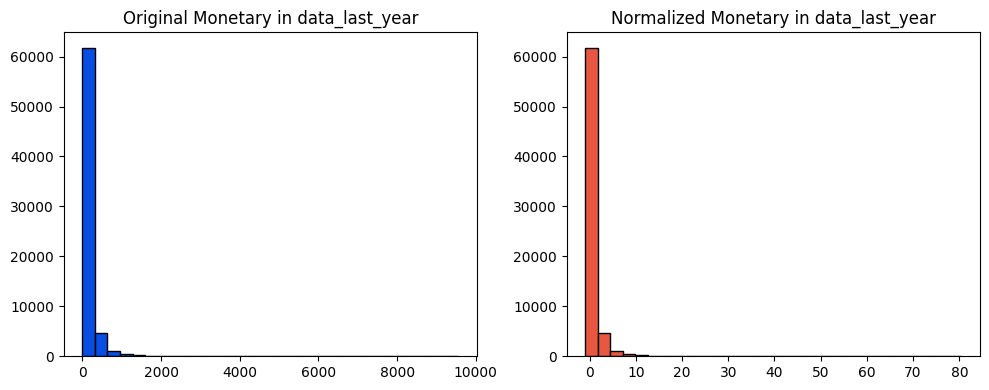

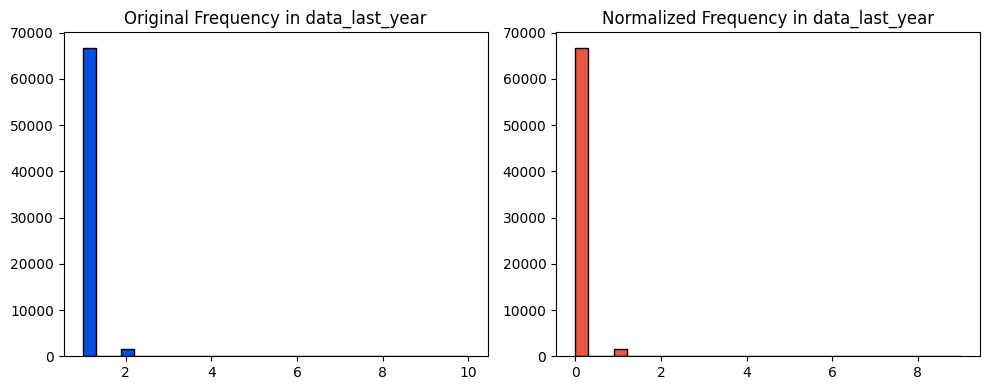

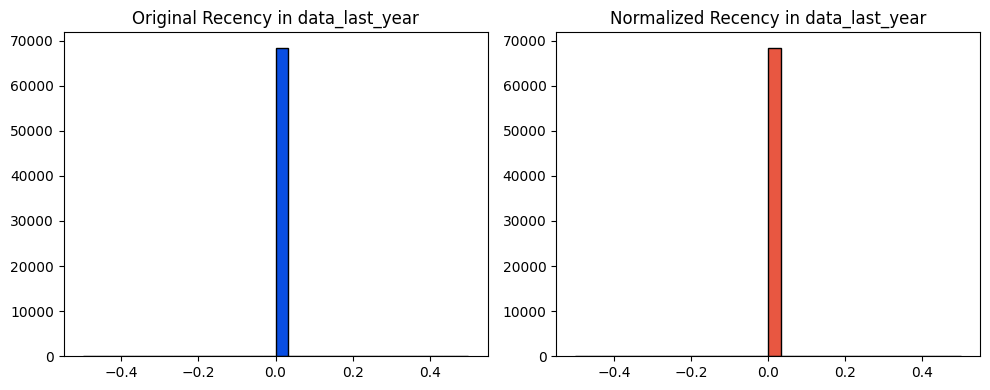

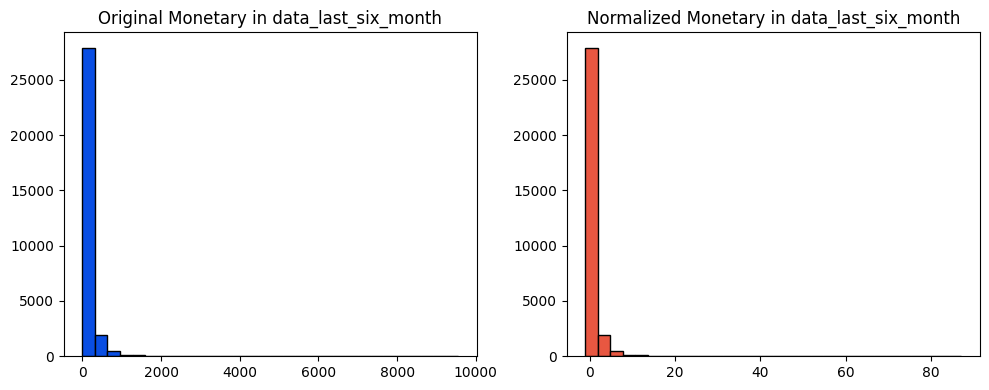

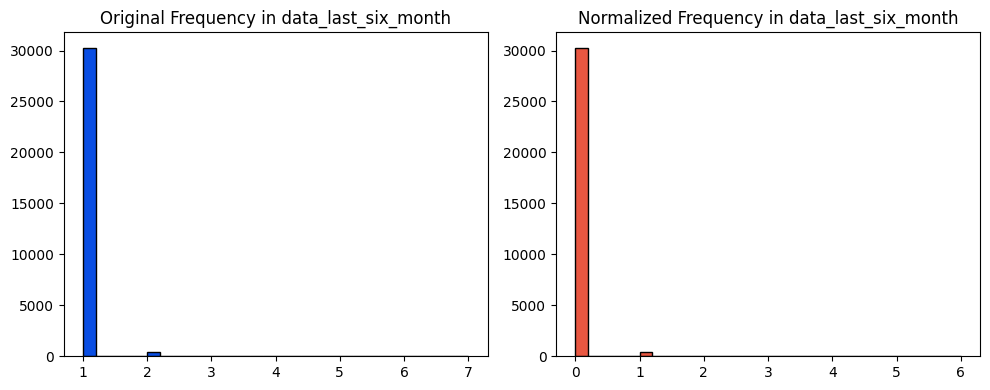

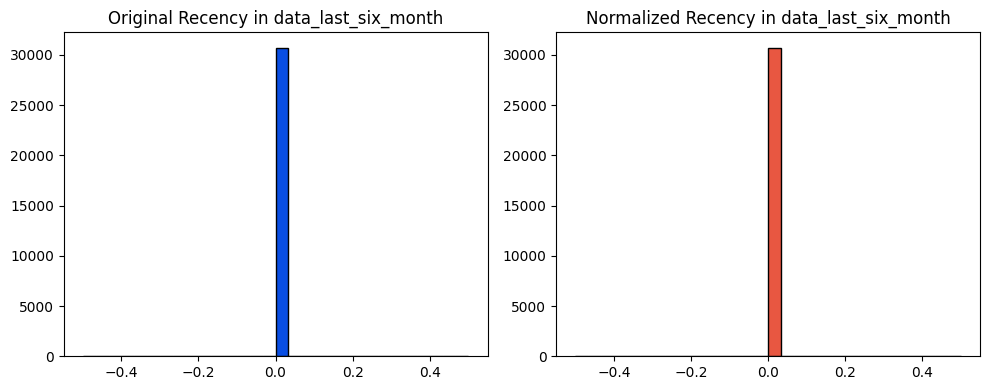

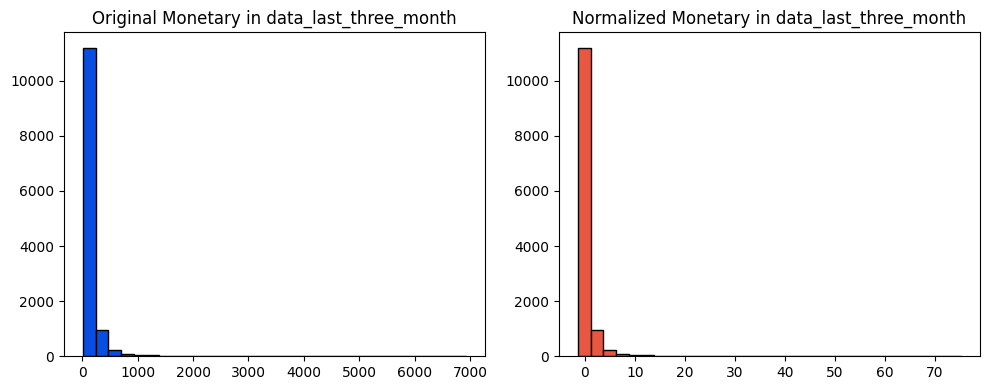

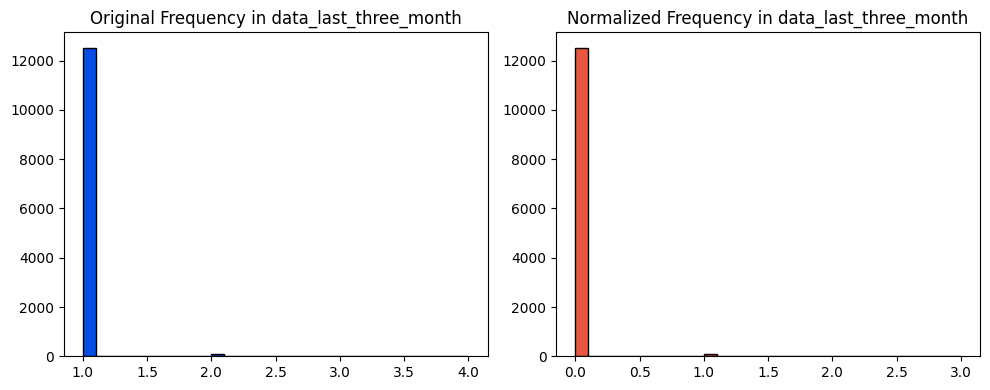

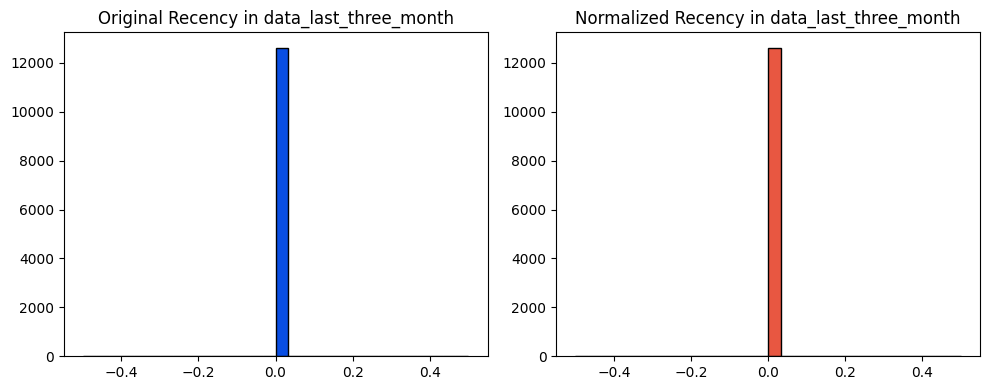

In [21]:
# Initialisation du RobustScaler
scaler = RobustScaler()

# Liste des noms des dataframes pour itération
dataframe_names = ['data_last_year', 'data_last_six_month', 'data_last_three_month']
dataframes = [data_last_year, data_last_six_month, data_last_three_month]

# Colonnes à normaliser
columns_to_scale = ['Monetary', 'Frequency', 'Recency']

for data_name, data in zip(dataframe_names, dataframes):
    # Convertir 'Recency' en jours
    data = convert_recency_to_days(data, 'Recency')
    
    # Copie des données originales pour la visualisation
    original_data = data[columns_to_scale].copy()

    # Application du RobustScaler
    data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

    # Affichage des distributions avant et après normalisation pour chaque colonne
    for column in columns_to_scale:
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.hist(original_data[column].dropna(), bins=30, color='#094ee3', edgecolor='black')
        plt.title(f'Original {column} in {data_name}')

        plt.subplot(1, 2, 2)
        plt.hist(data[column].dropna(), bins=30, color='#e85741', edgecolor='black')
        plt.title(f'Normalized {column} in {data_name}')

        plt.tight_layout()
        plt.show()

    D. Échantillonnage des données

In [22]:
# Initialiser un dictionnaire pour stocker les échantillons
samples = {}

# Liste des noms des dataframes pour itération
dataframe_names = ['data_last_year', 'data_last_six_month', 'data_last_three_month']
dataframes = [data_last_year, data_last_six_month, data_last_three_month]

# Échantillonnage aléatoire sans stratification qui contient 20% des données pour chaque DataFrame
for data_name, data in zip(dataframe_names, dataframes):
    sample, _ = train_test_split(data, test_size=0.8, random_state=42)
    samples[data_name] = sample

    E. Encoding des variables catégorielles

In [23]:
# Initialisation de OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Liste des noms des DataFrames échantillonnés pour itération
sample_names = ['data_last_year_sample', 'data_last_six_month_sample', 'data_last_three_month_sample']

# Dictionnaire des DataFrames échantillonnés pour itération
samples = {
    'data_last_year_sample': samples['data_last_year'],
    'data_last_six_month_sample': samples['data_last_six_month'],
    'data_last_three_month_sample': samples['data_last_three_month']
}

# Parcourir et transformer chaque DataFrame échantillonné
for sample_name, sample_data in samples.items():
    # Convertir la colonne 'Importance' en type de données catégorielles
    sample_data['Importance'] = sample_data['Importance'].astype('category')
    # Reshape nécessaire car fit_transform attend un 2D array
    importance_encoded = encoder.fit_transform(sample_data[['Importance']])
    column_names = encoder.get_feature_names_out(['Importance'])
    # Remplacer la colonne 'Importance' par les colonnes encodées
    samples[sample_name] = pd.concat([sample_data.drop(columns=['Importance']), pd.DataFrame(importance_encoded, index=sample_data.index, columns=column_names)], axis=1)

# Afficher le résultat pour un des échantillons
print("Exemple avec data_last_year_sample:")
samples['data_last_year_sample'].head()

Exemple avec data_last_year_sample:


,customer_unique_id,Recency,Frequency,Monetary,Importance_0.0,Importance_1.0
46622,aff69511dbf4e69a3d4f0cf0f46cd575,0.0,0.0,-0.668767,1.0,0.0
12239,2e40ccac66c1ee178735409e006d17ec,0.0,0.0,-0.273587,1.0,0.0
67504,ff60aefe219c1960b74d47d0fc553fc1,0.0,0.0,0.016775,1.0,0.0
22082,53aefda7ff8c61644d09043810bbf79f,0.0,0.0,0.943205,1.0,0.0
16705,3f04877b0a3842c23e36f422abe4393b,0.0,0.0,-0.238334,1.0,0.0


    F. Réduction dimensionnelle

In [24]:
# Initialisation de KernelPCA
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15, random_state=42)

# Dictionnaire pour stocker les DataFrames réduits
reduced_samples = {}

# Itération sur chaque DataFrame échantillonné dans le dictionnaire 'samples'
for sample_name, sample_data in samples.items():
    # Sélection des colonnes numériques pour la réduction de dimension
    data_numerique = sample_data[['Monetary', 'Frequency', 'Recency']]
    
    # Application de la réduction dimensionnelle avec Kernel PCA
    X_reduced = kpca.fit_transform(data_numerique)
    
    # Création d'un DataFrame pour les données réduites
    reduced_data = pd.DataFrame(X_reduced, columns=['KernelPCA1', 'KernelPCA2'], index=sample_data.index)
    
    # Ajout du DataFrame réduit au dictionnaire
    reduced_samples[sample_name + "_reduced"] = reduced_data

# Afficher les premières lignes du DataFrame réduit pour 'data_last_year_sample'
reduced_samples['data_last_year_sample_reduced'].head()

,KernelPCA1,KernelPCA2
46622,0.483806,-0.432195
12239,0.306444,0.561749
67504,-0.441593,0.508637
22082,-0.208941,-0.281713
16705,0.203155,0.634214


II. Simulation sur différentes périodes
***************************************

Score de silhouette pour K-Means avec 3 clusters pour data_last_year_sample_reduced: 0.59


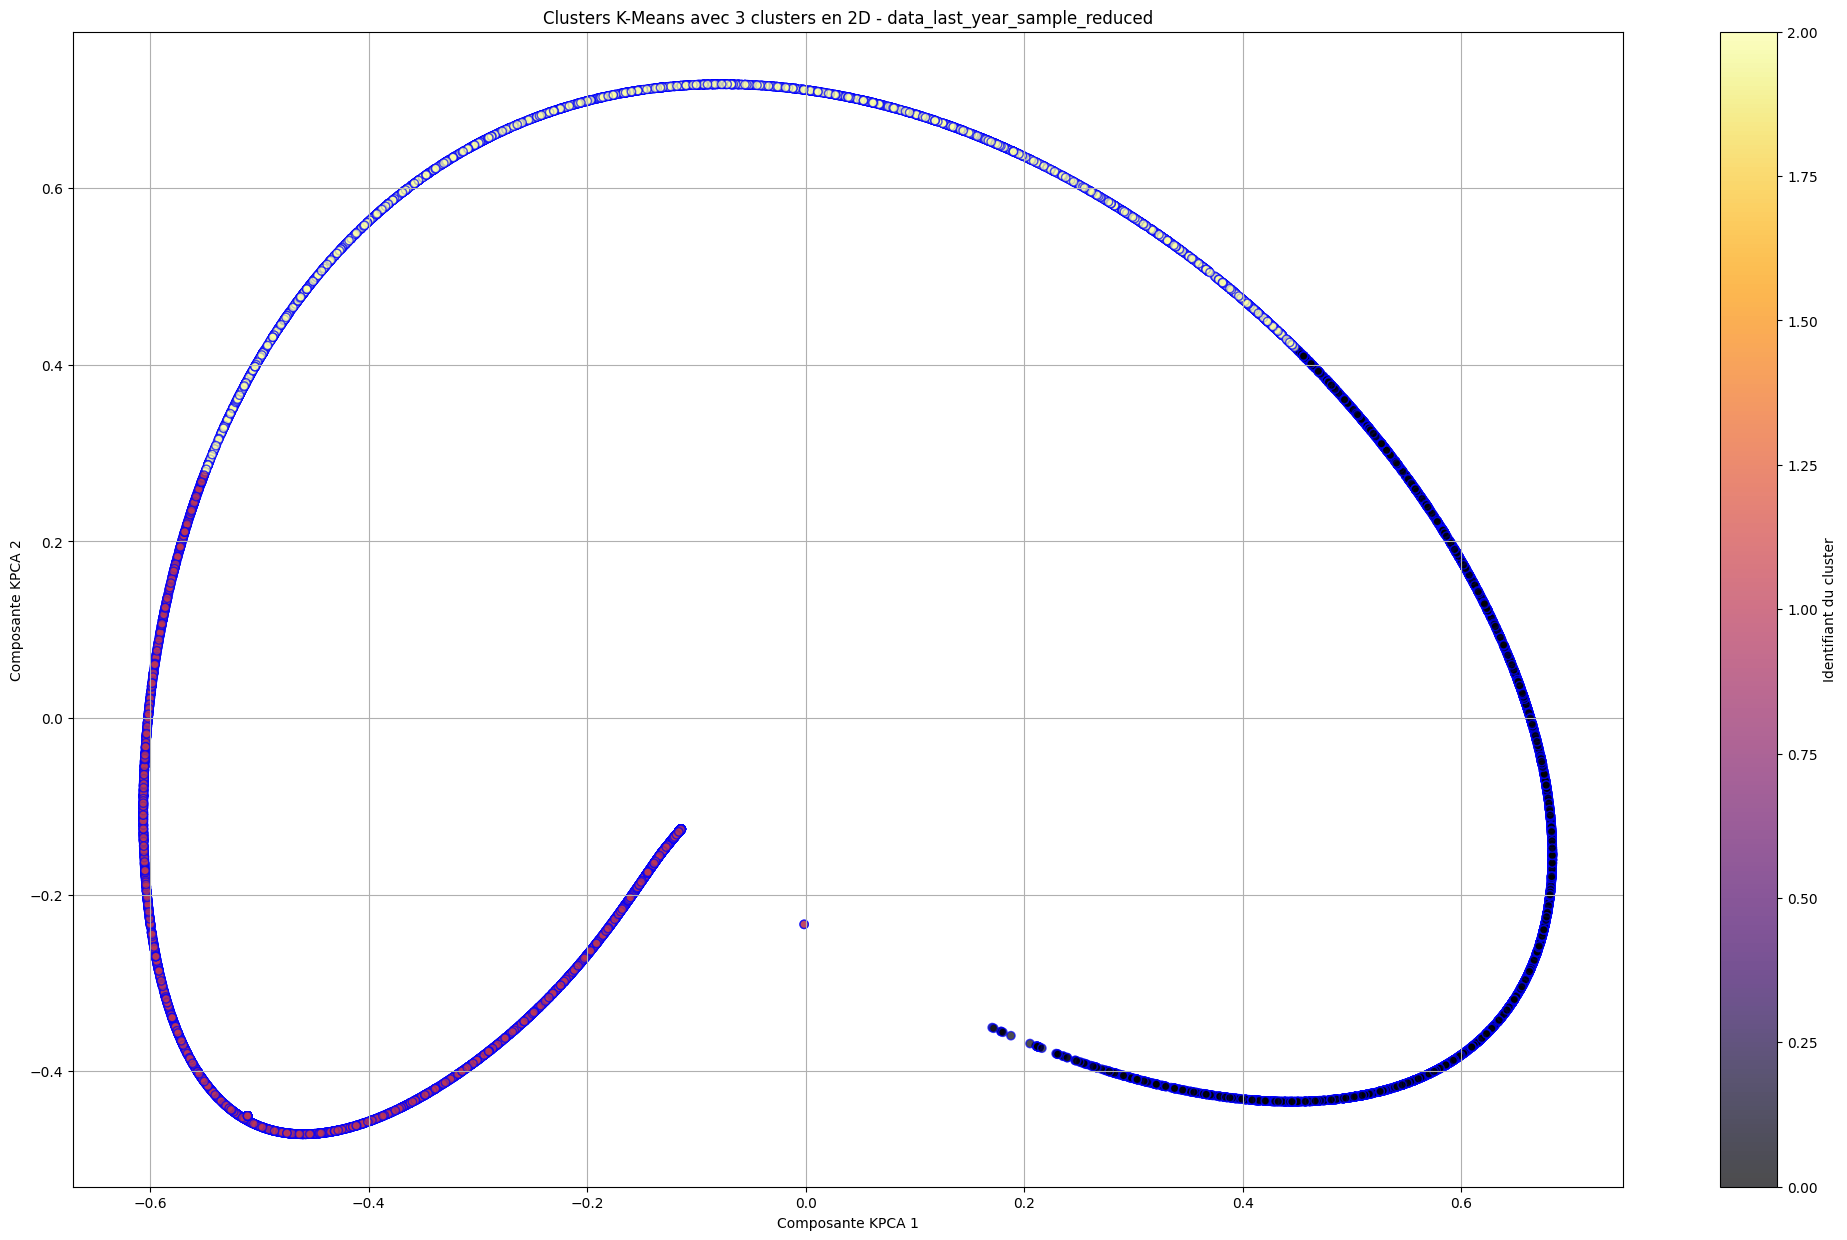

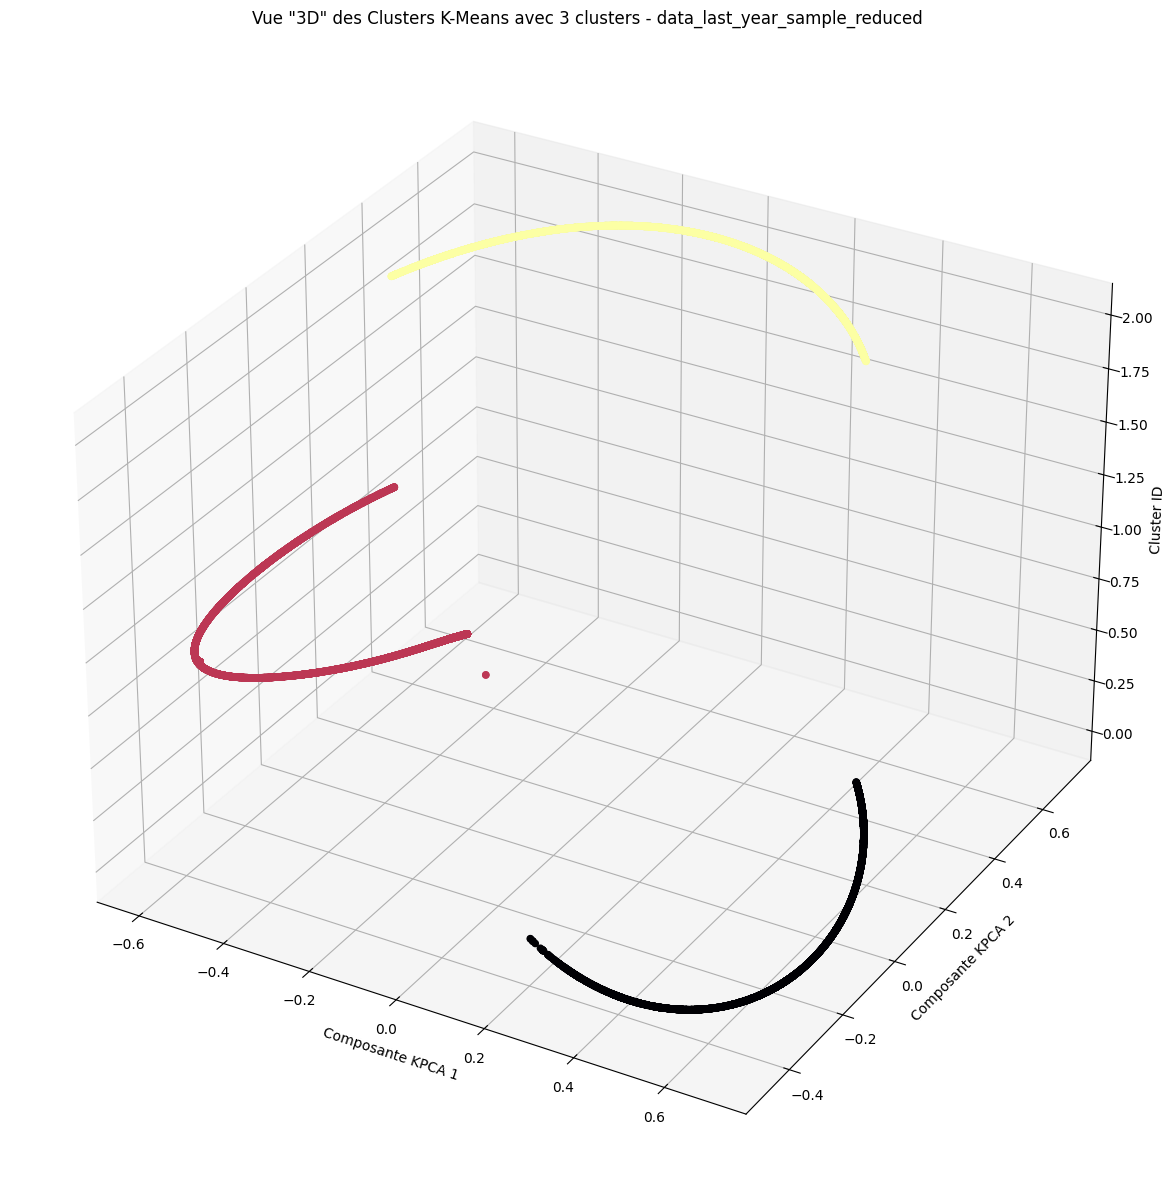

Score de silhouette pour K-Means avec 3 clusters pour data_last_six_month_sample_reduced: 0.58


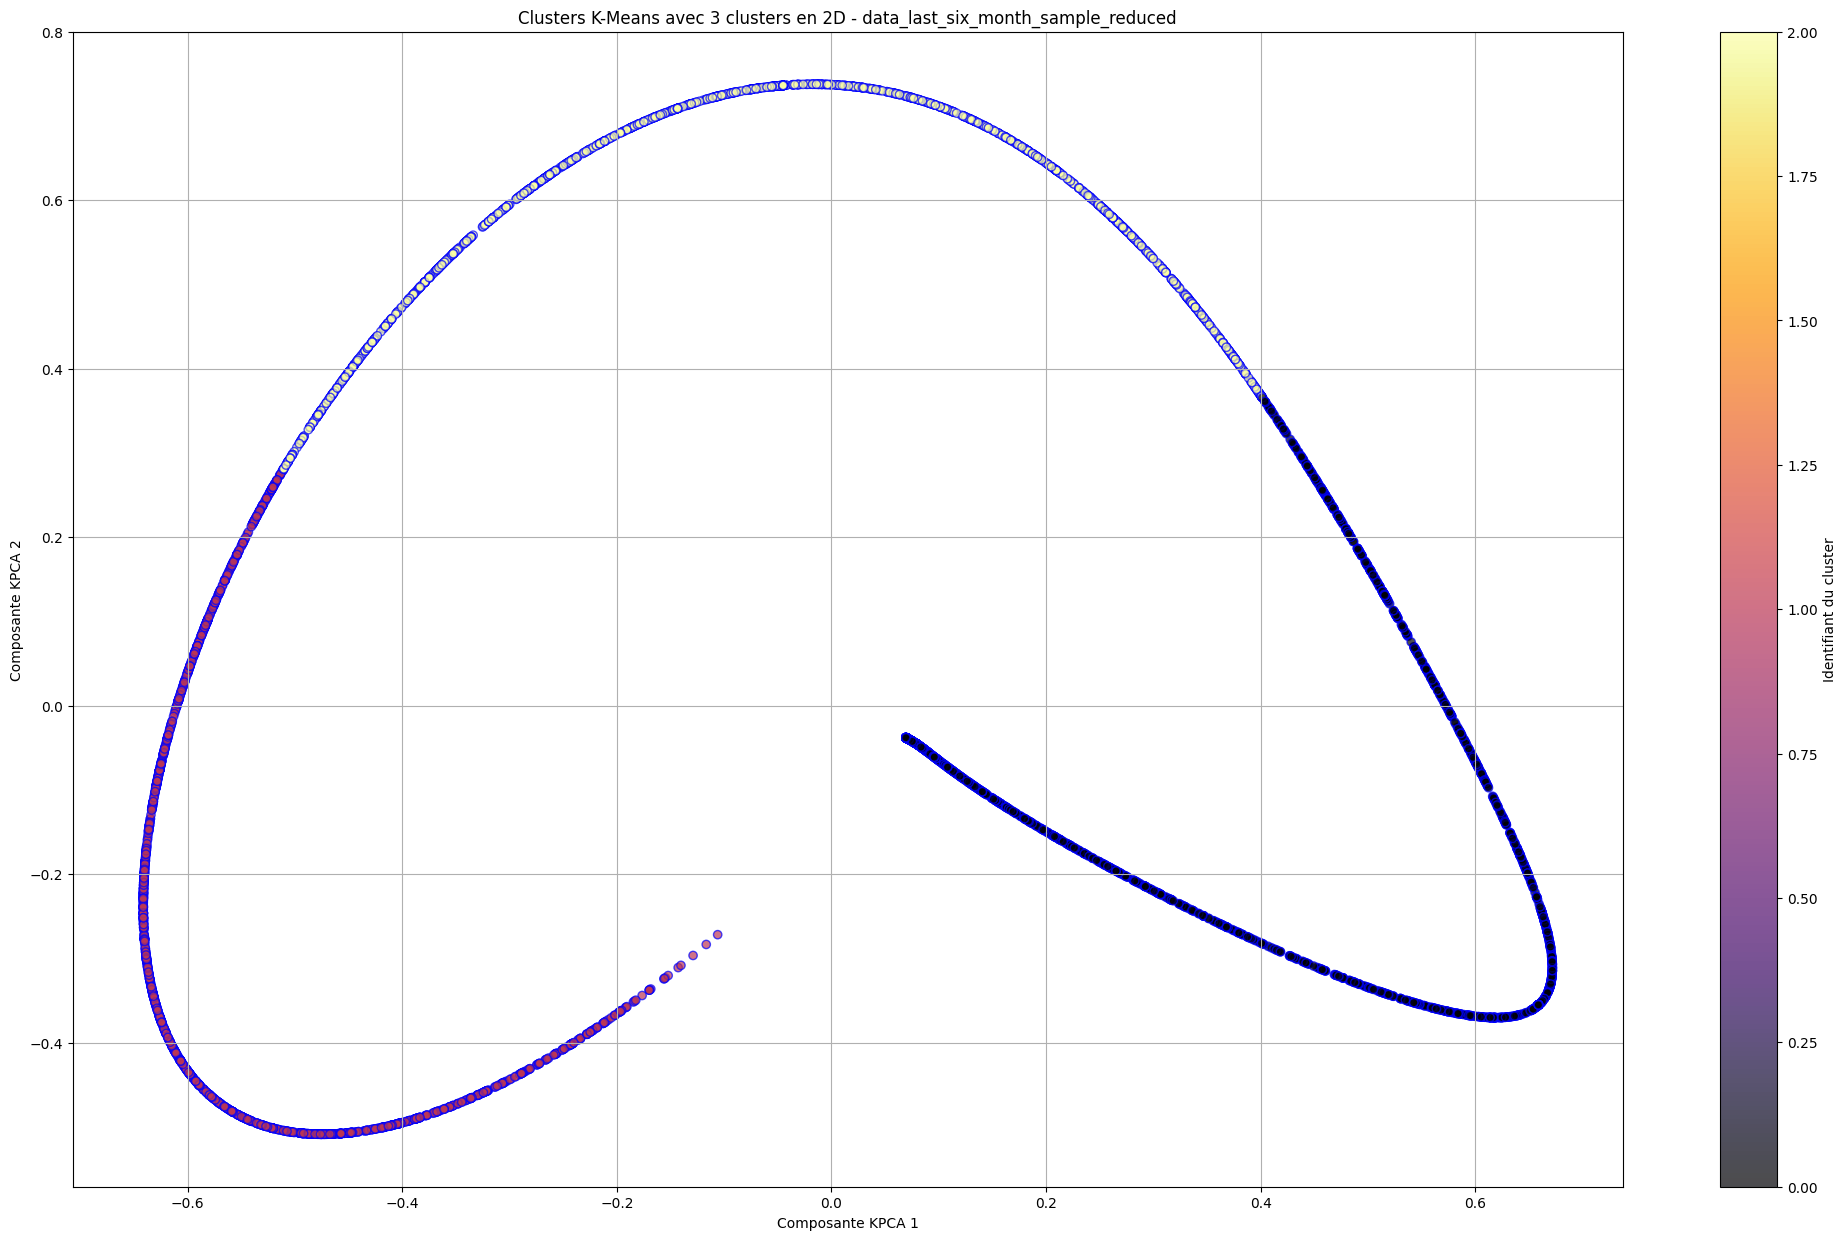

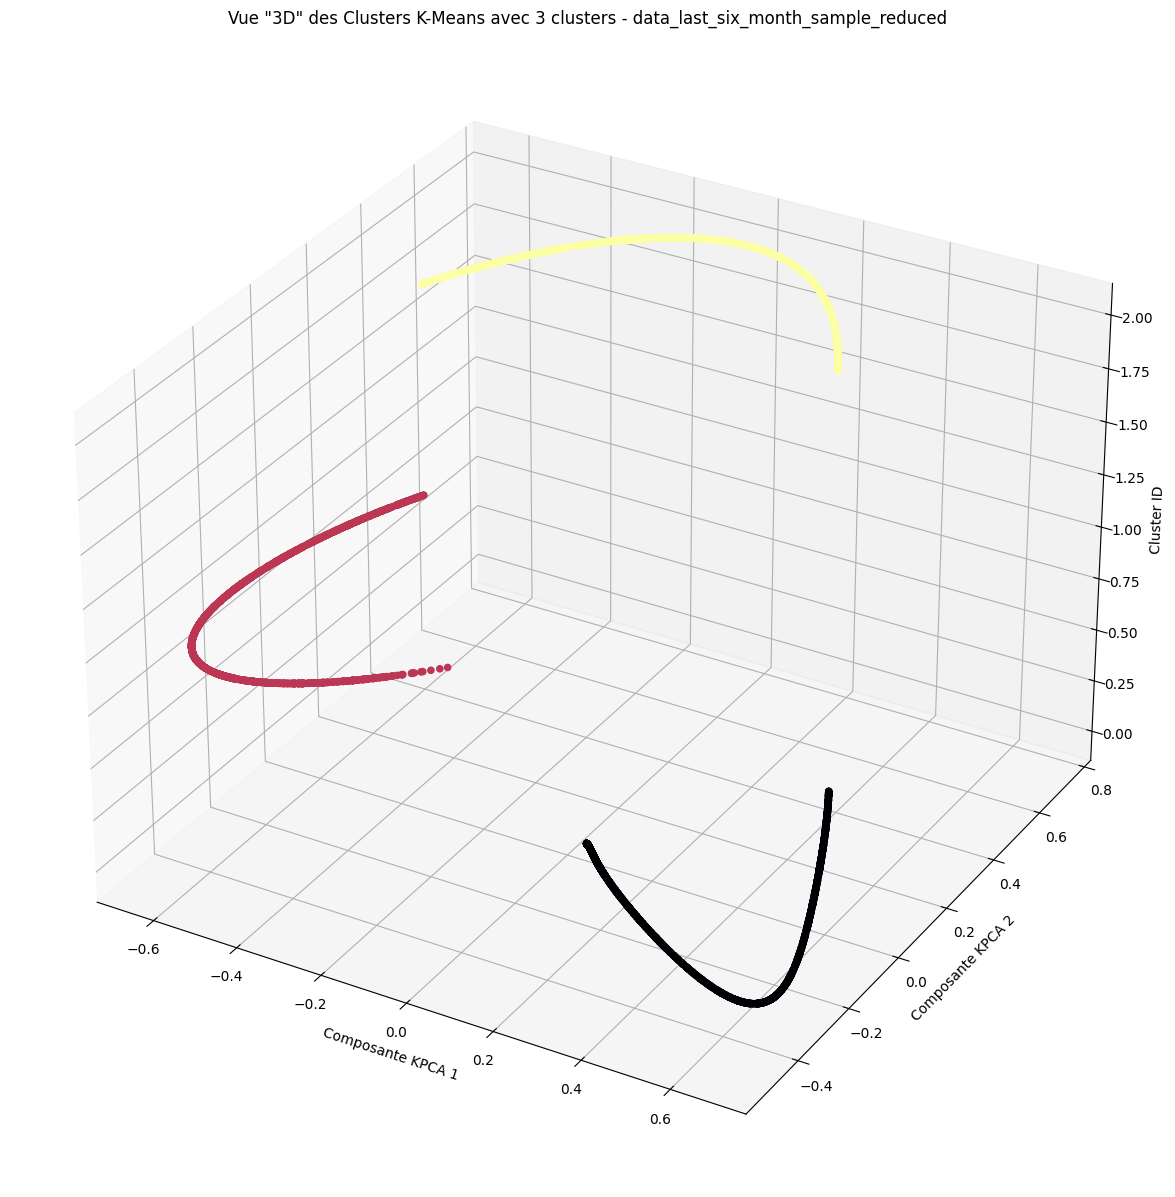

Score de silhouette pour K-Means avec 3 clusters pour data_last_three_month_sample_reduced: 0.66


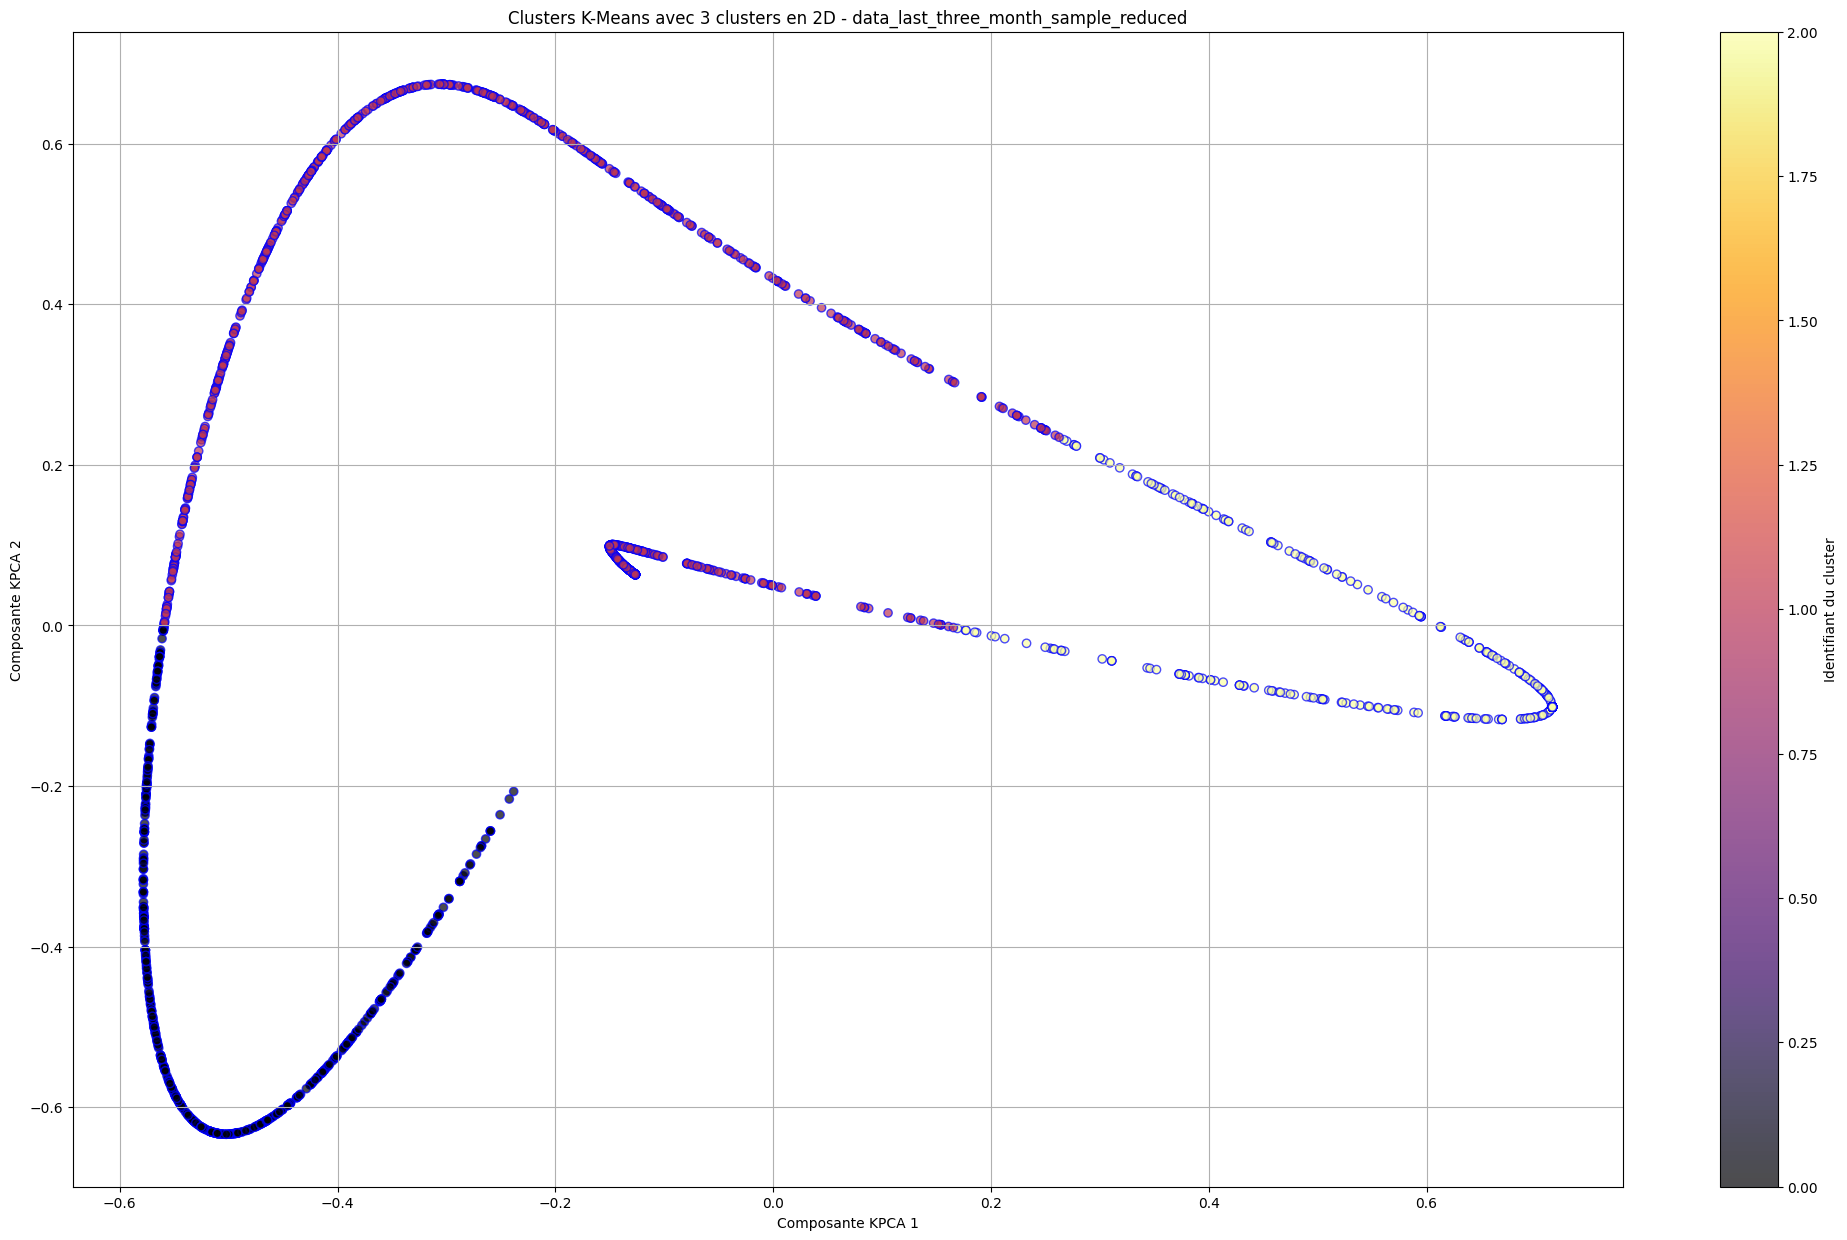

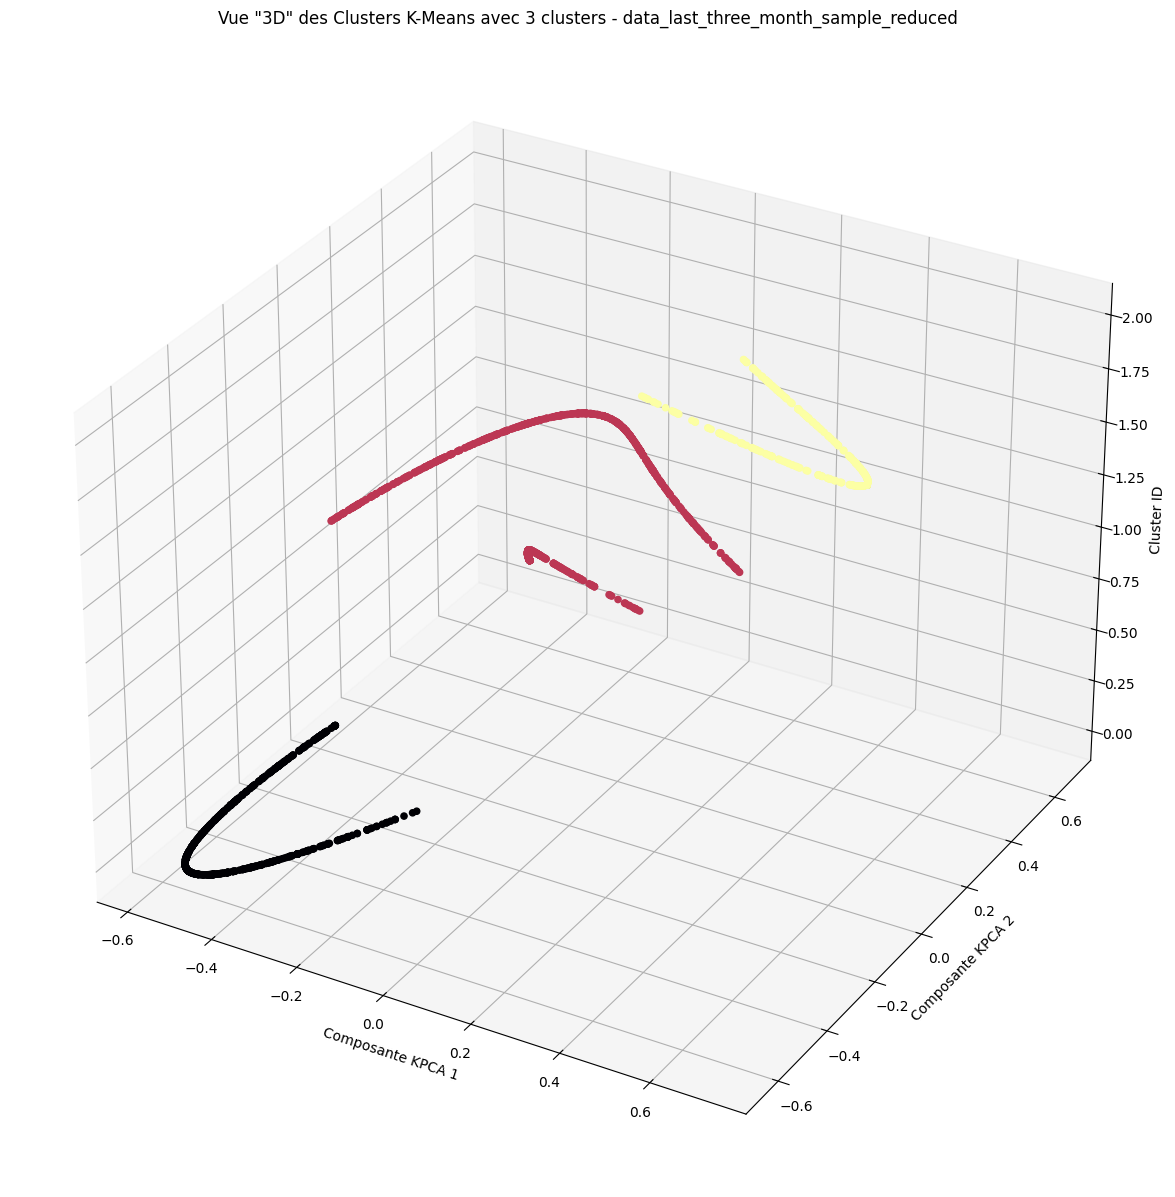

In [25]:
# Initialisation du modèle K-Means
kmeans = KMeans(n_clusters=3, random_state=42)

# Boucle sur chaque DataFrame de série temporelle
for data_name, reduced_data in reduced_samples.items():
    # Appliquer le clustering K-Means
    kmeans_labels = kmeans.fit_predict(reduced_data)
    samples[data_name.replace('_reduced', '')]['Cluster_KMeans'] = kmeans_labels
    
    # Calcul du score de silhouette
    silhouette_avg = silhouette_score(reduced_data, kmeans_labels)
    print(f'Score de silhouette pour K-Means avec 3 clusters pour {data_name}: {silhouette_avg:.2f}')
    
    # Visualisation 2D
    plt.figure(figsize=(25, 15))
    plt.scatter(reduced_data.iloc[:, 0], reduced_data.iloc[:, 1], c=kmeans_labels, cmap='inferno', alpha=0.7, edgecolors='b')
    plt.title(f'Clusters K-Means avec 3 clusters en 2D - {data_name}')
    plt.xlabel('Composante KPCA 1')
    plt.ylabel('Composante KPCA 2')
    plt.colorbar(label='Identifiant du cluster')
    plt.grid(True)
    plt.show()
    
    # Création d'un scatter plot "3D"
    fig = plt.figure(figsize=(25, 15))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(reduced_data.iloc[:, 0], reduced_data.iloc[:, 1], kmeans_labels, c=kmeans_labels, cmap='inferno', depthshade=False)
    ax.set_title(f'Vue "3D" des Clusters K-Means avec 3 clusters - {data_name}')
    ax.set_xlabel('Composante KPCA 1')
    ax.set_ylabel('Composante KPCA 2')
    ax.set_zlabel('Cluster ID')
    plt.show()

**Calcul de l'ARI (Ajusted Rank Index)**

ARI entre les 3 derniers mois et les 6 derniers mois: 0.01895084152768499
ARI entre les 6 derniers mois et l'année dernière: -0.001969560502945367
ARI entre les 3 derniers mois et l'année dernière: -0.018593654098521865


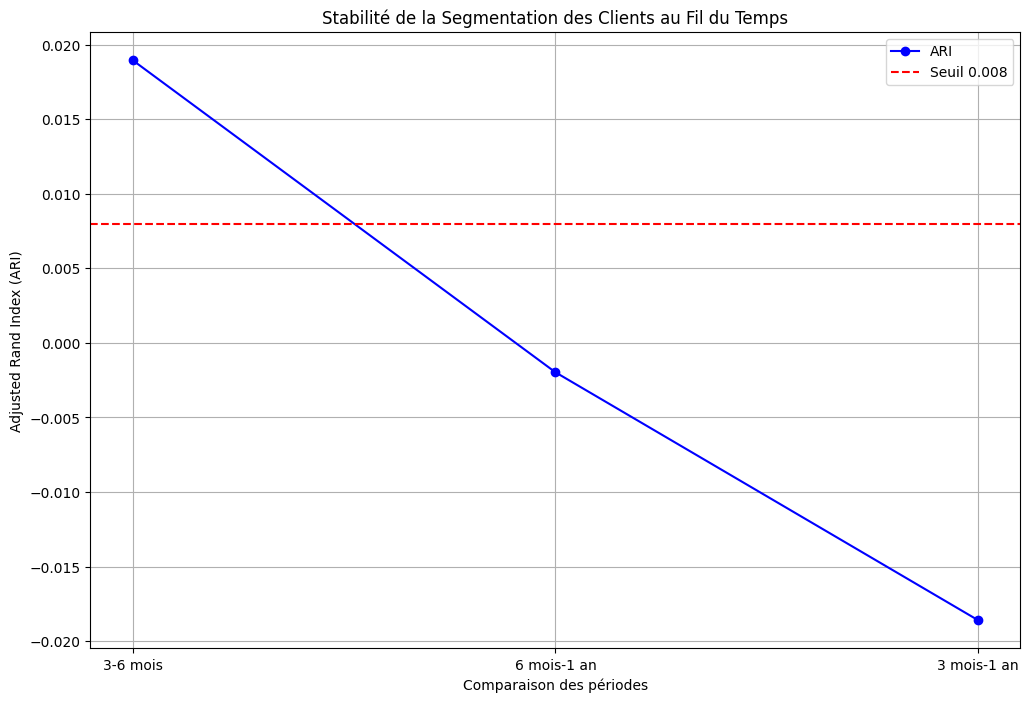

In [34]:
# Identifier les clients communs à toutes les périodes dans les échantillons
common_customers_samples = set(samples['data_last_year_sample']['customer_unique_id']) & \
                           set(samples['data_last_six_month_sample']['customer_unique_id']) & \
                           set(samples['data_last_three_month_sample']['customer_unique_id'])

# Filtrer chaque échantillon réduit pour inclure uniquement les clients communs
data_last_three_month_reduced_common = reduced_samples['data_last_three_month_sample_reduced'].loc[
    reduced_samples['data_last_three_month_sample_reduced'].index.isin(common_customers_samples)]
data_last_six_month_reduced_common = reduced_samples['data_last_six_month_sample_reduced'].loc[
    reduced_samples['data_last_six_month_sample_reduced'].index.isin(common_customers_samples)]
data_last_year_reduced_common = reduced_samples['data_last_year_sample_reduced'].loc[
    reduced_samples['data_last_year_sample_reduced'].index.isin(common_customers_samples)]

# S'assurer que les labels des clusters sont accessibles dans les échantillons communs filtrés
labels_last_three_month_common = samples['data_last_three_month_sample'].loc[
    samples['data_last_three_month_sample']['customer_unique_id'].isin(common_customers_samples), 'Cluster_KMeans']
labels_last_six_month_common = samples['data_last_six_month_sample'].loc[
    samples['data_last_six_month_sample']['customer_unique_id'].isin(common_customers_samples), 'Cluster_KMeans']
labels_last_year_common = samples['data_last_year_sample'].loc[
    samples['data_last_year_sample']['customer_unique_id'].isin(common_customers_samples), 'Cluster_KMeans']

# Calculer l'ARI entre les différentes périodes en utilisant les labels des clusters
ari_last_three_month_six_month = adjusted_rand_score(labels_last_three_month_common, labels_last_six_month_common)
ari_last_three_month_year = adjusted_rand_score(labels_last_three_month_common, labels_last_year_common)
ari_last_six_month_year = adjusted_rand_score(labels_last_six_month_common, labels_last_year_common)

# Afficher les résultats de l'ARI
print(f"ARI entre les 3 derniers mois et les 6 derniers mois: {ari_last_three_month_six_month}")
print(f"ARI entre les 6 derniers mois et l'année dernière: {ari_last_six_month_year}")
print(f"ARI entre les 3 derniers mois et l'année dernière: {ari_last_three_month_year}")

# Définir les labels des périodes
period_labels = ['3-6 mois', '6 mois-1 an', '3 mois-1 an']
ari_values = [ari_last_three_month_six_month, ari_last_six_month_year, ari_last_three_month_year]

# Afficher un graphique pour visualiser où l'ARI passe en dessous de 0.008
plt.figure(figsize=(12, 8))
plt.plot(period_labels, ari_values, marker='o', linestyle='-', color='b', label='ARI')
plt.axhline(y=0.008, color='r', linestyle='--', label='Seuil 0.008')
plt.xlabel('Comparaison des périodes')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.title('Stabilité de la Segmentation des Clients au Fil du Temps')
plt.legend()
plt.grid(True)
plt.show()

III. Analyse de la stabilité des clusters
*****************************************

- ARI entre les 3 derniers mois et les 6 derniers mois : Environ 0.02- ARI entre les 6 derniers mois et l'année dernière : Environ -0.002

- ARI entre les 3 derniers mois et l'année dernière : Environ -0.025


Analyse des ARI
L'analyse de l'ARI fournit des informations essentielles sur la stabilité des clusters au fil du temps :

- Comparaison des 3 derniers mois et des 6 derniers mois :
	Un ARI de 0.02 montre une stabilité raisonnable des clusters entre ces périodes. Cela indique que les comportements des clients restent similaires sur une période de 3 àes clients.

- Comparaison des 6 derniers mois et de l'année dernière :
	Un- ARI2d'environ 0.005 montre une certaine stabilité, mais inférieure au seuil de 0.008. Cela indique que les clusters commencent à se détériorer au-

- Comparaison des 3 derniers mois et de l'année dernière :
	Un ARI d'environ -0.02 suggère des différences significatives dans les clusters formés sur ces périodes. Cela indique une dégradation de la stabilité des clusters sur une période d'un an, probablement dû à des changements dans les comportements des clients.

Cette variabilité suggère que les comportements d'achat des clients d'Olist évoluent significativement sur ces périodes, probablement influencés par des facteurs saisonniers, des tendances de marché, ou des événements spécifiques.delà de 6 mois.pertinente des clients.

IV. Recommandation sur la fréquence de mises à jour
***************************************************

Face à l'instabilité des clusters, il est crucial d'adopter une approche proactive pour leur mise à jour. Une actualisation trimestrielle du modèle de segmentation est recommandée, car elle permet de capturer les évolutions des comportements clients sans provoquer de surcharge opérationnelle. Ainsi, la segmentation reste pertinente et utile pour l'équipe marketing, qui peut cibler les clients de manière plus précise et élaborer des stratégies promotionnelles adaptées aux besoins et aux préférences en constante évolution de la clientèle